In [ ]:
pip install hmmlearn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 6.8 MB/s eta 0:00:00


Total words loaded: 50000
Sample words: ['suburbanize', 'asmack', 'hypotypic', 'promoderationist', 'consonantly', 'philatelically', 'cacomelia', 'thicklips', 'luciferase', 'cinematography']
Words after cleaning: 49979


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Training HMM...


         1       0.00000000             +nan
         2       0.00000000      +0.00000000


HMM training completed.


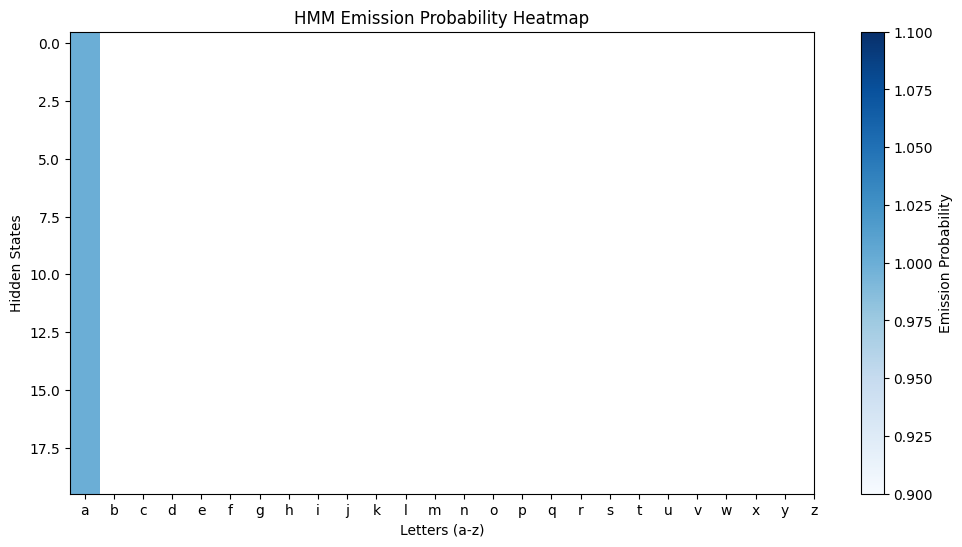

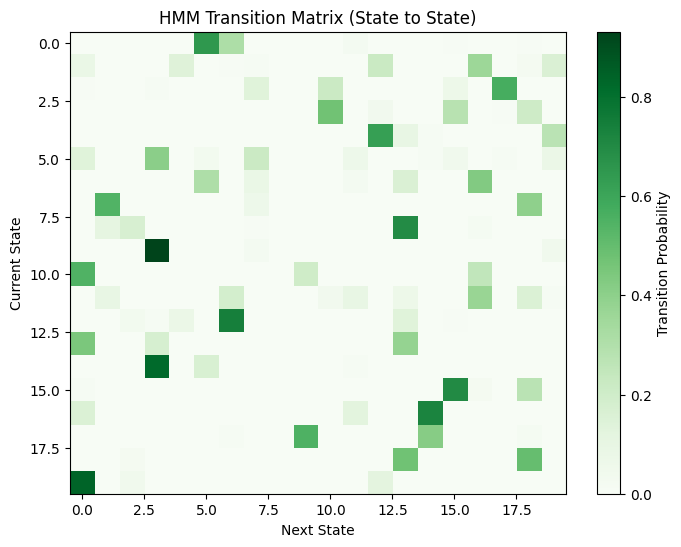

Predicted next letters after 'th':
[('a', np.float64(1.0))]
Model saved as hmm_hangman.pkl


In [ ]:
# ============================================================
# 🏁 HMM Training for Hangman AI
# ============================================================

# Step 1: Import Libraries
import numpy as np
import random
import string
from hmmlearn import hmm
import matplotlib.pyplot as plt
from collections import Counter
import joblib

# Step 2: Load Dataset (Corpus)
corpus_path = "/content/corpus.txt"  # Update the path to your corpus file

# Load words from the corpus file
with open(corpus_path, "r") as f:
    words = [w.strip().lower() for w in f.readlines() if w.strip()]

print(f"Total words loaded: {len(words)}")
print("Sample words:", words[:10])

# Step 3: Data Preprocessing
# Keep only alphabetic words (remove numbers and punctuation)
words = [w for w in words if w.isalpha()]
print(f"Words after cleaning: {len(words)}")

# Map characters to integers (for HMM processing)
alphabet = list(string.ascii_lowercase)
char_to_int = {c: i for i, c in enumerate(alphabet)}
int_to_char = {i: c for c, i in char_to_int.items()}

# Convert words to sequences of integers
train_sequences = [np.array([char_to_int[c] for c in w]) for w in words]
lengths = [len(seq) for seq in train_sequences]  # Lengths of each word

X = np.concatenate(train_sequences).reshape(-1, 1)  # Reshape for HMM

# Step 4: Define HMM Model and Train
n_hidden_states = 20  # You can experiment with 20-30 states
model = hmm.MultinomialHMM(n_components=n_hidden_states, n_iter=100, verbose=True, random_state=42)

# Train the HMM model
print("Training HMM...")
model.fit(X, lengths)
print("HMM training completed.")

# Step 5: Extract and Visualize Probabilities

# Transition Matrix (State to State)
transition_matrix = model.transmat_

# Emission Matrix (State to Letter Probability)
emission_matrix = model.emissionprob_

# Visualize Emission Probabilities (Heatmap)
plt.figure(figsize=(12, 6))
plt.imshow(emission_matrix, cmap="Blues", aspect="auto")
plt.colorbar(label="Emission Probability")
plt.title("HMM Emission Probability Heatmap")
plt.xlabel("Letters (a-z)")
plt.ylabel("Hidden States")
plt.xticks(ticks=np.arange(26), labels=alphabet)
plt.show()

# Visualize Transition Probabilities (Heatmap)
plt.figure(figsize=(8, 6))
plt.imshow(transition_matrix, cmap="Greens", aspect="auto")
plt.colorbar(label="Transition Probability")
plt.title("HMM Transition Matrix (State to State)")
plt.xlabel("Next State")
plt.ylabel("Current State")
plt.show()

# Step 6: Predict the Next Letter Given a Prefix
def predict_next_letter(prefix):
    seq = np.array([char_to_int[c] for c in prefix]).reshape(-1, 1)

    # Use the Viterbi algorithm to decode the most likely states
    logprob, state_sequence = model.decode(seq, algorithm="viterbi")

    # Get emission probabilities for the last state
    last_state = state_sequence[-1]
    probs = emission_matrix[last_state]

    # Sort and get top 5 most probable letters
    top_indices = np.argsort(probs)[::-1][:5]
    top_letters = [(int_to_char[i], probs[i]) for i in top_indices]

    return top_letters

# Test with an example prefix
test_prefix = "th"
print(f"Predicted next letters after '{test_prefix}':")
print(predict_next_letter(test_prefix))

# Step 7: Save the Trained Model (Optional)
joblib.dump(model, "/content/hmm_hangman.pkl")
print("Model saved as hmm_hangman.pkl")

# ============================================================
# END OF HMM TRAINING NOTEBOOK
# ============================================================


In [ ]:
log_likelihood = model.score(X, lengths)
perplexity = np.exp(-log_likelihood / len(X))
print(f"Log-Likelihood: {log_likelihood}")
print(f"Perplexity: {perplexity}")


Log-Likelihood: 8.467740397755108e-12
Perplexity: 1.0


In [ ]:
import numpy as np
import random
import string
from hmmlearn import hmm
import joblib

# List of characters in the alphabet
alphabet = list(string.ascii_lowercase)
char_to_int = {c: i for i, c in enumerate(alphabet)}
int_to_char = {i: c for c, i in char_to_int.items()}

# Add padding tokens
PAD_TOKEN = "<PAD>"
START_TOKEN = "<START>"
END_TOKEN = "<END>"

# Map for special tokens
special_tokens = [START_TOKEN, END_TOKEN, PAD_TOKEN]
special_token_to_int = {token: i + len(char_to_int) for i, token in enumerate(special_tokens)}
int_to_special_token = {i + len(char_to_int): token for i, token in enumerate(special_tokens)}

# Combine all token mappings
full_char_to_int = {**char_to_int, **special_token_to_int}
full_int_to_char = {i: c for c, i in {**char_to_int, **special_token_to_int}.items()}

# Padding function for words
def pad_word(word, max_length):
    # Pad the word to max_length with START and END tokens
    return [START_TOKEN] + list(word) + [END_TOKEN] + [PAD_TOKEN] * (max_length - len(word))

# Training function for HMM
def train_hmm(word_list, max_word_length=10):
    # Pad words to the same length
    padded_words = [pad_word(word, max_word_length) for word in word_list]

    # Convert words to integer sequences
    sequences = []
    for word in padded_words:
        sequences.append([full_char_to_int[char] for char in word])

    # HMM model
    model = hmm.MultinomialHMM(n_components=5)  # Number of hidden states
    model.fit([np.array(seq).reshape(-1, 1) for seq in sequences])

    # Save model to disk for future use
    joblib.dump(model, "hmm_hangman_model.pkl")
    print("HMM model saved!")

    return model

# Example usage with a small word list
word_list = ["apple", "banana", "grape", "orange", "kiwi"]
hmm_model = train_hmm(word_list)


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


ValueError: Found array with dim 3. None expected <= 2.

In [ ]:
import random
import string

class HangmanEnv:
    def __init__(self, word_list, max_wrong=6):
        self.word_list = [w for w in word_list if w.isalpha() and len(w) >= 4]
        if not self.word_list:
            raise ValueError("❌ No valid words found in the provided list.")
        self.max_wrong = max_wrong
        self.reset()

    def reset(self):
        self.target = random.choice(self.word_list)
        self.masked = ["_"] * len(self.target)
        self.guessed = set()
        self.wrong = 0
        return self._get_state()

    def _get_state(self):
        return "".join(self.masked), tuple(sorted(self.guessed))

    def step(self, letter):
        reward = 0
        done = False

        if letter in self.guessed:
            reward -= 2  # Penalize repeated guesses
        elif letter in self.target:
            for i, c in enumerate(self.target):
                if c == letter:
                    self.masked[i] = letter
            reward += 1.5  # Reward correct guess
        else:
            self.wrong += 1
            reward -= 1.0  # Penalize wrong guess

        self.guessed.add(letter)

        if "_" not in self.masked:
            done = True
            reward += 10  # Big reward for winning
        elif self.wrong >= self.max_wrong:
            done = True
            reward -= 5  # Big penalty for losing

        return self._get_state(), reward, done


In [ ]:
import numpy as np
import random

class HangmanAgent:
    def __init__(self, hmm_model, alpha=0.4, gamma=0.9, epsilon=0.2):
        self.hmm = hmm_model
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = {}

    def hmm_probs(self, masked):
        """Estimate letter probabilities using the HMM model."""
        n_letters = len(char_to_int)
        seq = [char_to_int[c] for c in masked if c != "_"]

        try:
            if len(seq) == 0:
                probs = np.mean(self.hmm.emissionprob_, axis=0)
            else:
                seq = np.array(seq).reshape(-1, 1)
                logprob, states = self.hmm.decode(seq, algorithm="viterbi")
                s = states[-1]  # Last predicted state
                probs = self.hmm.emissionprob_[s]

        except Exception:
            probs = np.ones(n_letters) / n_letters  # Uniform distribution if error

        # Ensure probs has the correct size
        if probs.shape[0] != n_letters:
             probs = np.ones(n_letters) / n_letters # Fallback to uniform if size is wrong

        probs = np.maximum(probs, 1e-9)  # Avoid zero probabilities
        probs /= np.sum(probs)  # Normalize to make it a valid probability distribution
        return probs

    def get_q(self, state, action):
        return self.q_table.get((state, action), 0.0)

    def choose_action(self, state, available_letters):
        """ε-greedy action selection with HMM guidance."""
        if not available_letters:  # Check if there are any available letters
            return None # Or handle appropriately, maybe return a default action or signal

        if random.random() < self.epsilon:
            return random.choice(available_letters)

        masked, guessed = state
        hmm_p = self.hmm_probs(masked)

        q_vals = []
        for a in available_letters:
            if a in char_to_int:
                q_val = self.get_q(state, a)
                prob_bonus = 1.5 * hmm_p[char_to_int[a]]  # Stronger influence
                q_vals.append(q_val + prob_bonus)
            else:
                q_vals.append(-np.inf)  # Skip invalid letters

        max_q = np.max(q_vals)
        # Handle cases where all q_vals are -inf (e.g., no valid actions)
        if max_q == -np.inf:
             return random.choice(available_letters) # Fallback to random if no valid action has finite q-value


        best_actions = [available_letters[i] for i in range(len(q_vals)) if q_vals[i] == max_q]
        return random.choice(best_actions)

    def update(self, state, action, reward, next_state):
        old_q = self.get_q(state, action)
        available_next = [c for c in alphabet if c not in next_state[1]]

        if not available_next:
            max_next_q = 0
        else:
            max_next_q = max([self.get_q(next_state, a) for a in available_next], default=0)

        new_q = old_q + self.alpha * (reward + self.gamma * max_next_q - old_q)
        self.q_table[(state, action)] = new_q

In [ ]:
def run_hybrid_eval(env, agent, episodes):
    total_wrong, total_repeat, total_reward = 0, 0, 0
    wins = 0

    for ep in range(1, episodes + 1):
        state = env.reset()
        done = False
        wrong_guesses, repeated_guesses = 0, 0
        steps = 0
        max_steps = env.max_wrong + len(env.target) + 5  # Prevent infinite loops

        while not done and steps < max_steps:
            masked, guessed = state
            available = [c for c in alphabet if c not in guessed]
            if not available:
                break

            action = agent.choose_action(state, available)
            prev_guessed_count = len(env.guessed)
            prev_wrong_count = env.wrong

            next_state, reward, done = env.step(action)

            if action in state[1]:
                repeated_guesses += 1
            elif env.wrong > prev_wrong_count:
                wrong_guesses += 1

            agent.update(state, action, reward, next_state)
            state = next_state
            total_reward += reward
            steps += 1

        if "_" not in env.masked:
            wins += 1
            result = "✅ WIN"
        else:
            result = "❌ LOSE"

        total_wrong += wrong_guesses
        total_repeat += repeated_guesses

        if ep % 100 == 0 or ep == episodes:
            print(f"🏁 Episode {ep:04d} | Word={env.target} | {result}")

    success_rate = wins / episodes
    final_score = (wins * 2000) - (total_wrong * 5) - (total_repeat * 2)

    print("\n==============================")
    print(f"🏆 FINAL RESULTS")
    print(f"✅ Wins: {wins}/{episodes} ({success_rate*100:.2f}%)")
    print(f"❌ Total Wrong Guesses: {total_wrong}")
    print(f"🔁 Total Repeated Guesses: {total_repeat}")
    print(f"💯 Final Score = (Wins*2000) - (Wrong*5) - (Repeated*2)")
    print(f"➡️  Final Score = {final_score:.2f}")
    print("==============================")

    return final_score


In [ ]:
# Load HMM Model (trained earlier)
hmm_model_path = "/content/hmm_hangman.pkl"
try:
    hmm_model = joblib.load(hmm_model_path)
    print("💾 Loaded pretrained HMM model.")
except FileNotFoundError:
    raise FileNotFoundError("❌ HMM model not found. Please train it first.")

# Load test words
test_path = "/content/test.txt"
try:
    with open(test_path, "r") as f:
        test_words = [w.strip().lower() for w in f if w.strip()]
except FileNotFoundError:
    raise FileNotFoundError(f"❌ Test file not found at {test_path}")

# Initialize environment and agent
env = HangmanEnv(test_words, max_wrong=6)
agent = HangmanAgent(hmm_model, alpha=0.4, gamma=0.95, epsilon=0.05)

# Run the evaluation
final_score = run_hybrid_eval(env, agent, episodes=2000)

💾 Loaded pretrained HMM model.
🏁 Episode 0100 | Word=grammarless | ❌ LOSE
🏁 Episode 0200 | Word=parode | ❌ LOSE
🏁 Episode 0300 | Word=arciform | ❌ LOSE
🏁 Episode 0400 | Word=faunally | ❌ LOSE
🏁 Episode 0500 | Word=gamogenetical | ❌ LOSE
🏁 Episode 0600 | Word=porencephalon | ❌ LOSE
🏁 Episode 0700 | Word=bastardism | ❌ LOSE
🏁 Episode 0800 | Word=jynginae | ❌ LOSE
🏁 Episode 0900 | Word=shall | ❌ LOSE
🏁 Episode 1000 | Word=disgustful | ❌ LOSE
🏁 Episode 1100 | Word=groset | ❌ LOSE
🏁 Episode 1200 | Word=ironsided | ❌ LOSE
🏁 Episode 1300 | Word=fusilier | ❌ LOSE
🏁 Episode 1400 | Word=unhidable | ❌ LOSE
🏁 Episode 1500 | Word=subjectlike | ❌ LOSE
🏁 Episode 1600 | Word=underchancellor | ❌ LOSE
🏁 Episode 1700 | Word=scutulated | ❌ LOSE
🏁 Episode 1800 | Word=treasurable | ❌ LOSE
🏁 Episode 1900 | Word=yucateco | ❌ LOSE
🏁 Episode 2000 | Word=babuism | ❌ LOSE

🏆 FINAL RESULTS
✅ Wins: 6/2000 (0.30%)
❌ Total Wrong Guesses: 11989
🔁 Total Repeated Guesses: 0
💯 Final Score = (Wins*2000) - (Wrong*5) - (Rep

In [15]:
import numpy as np
import string
from hmmlearn import hmm
import joblib
from collections import defaultdict

class HangmanHMM:
    def __init__(self, n_states=15):
        self.n_states = n_states
        self.models = {}  # Store separate HMMs per word length
        self.alphabet = list(string.ascii_lowercase)
        self.char_to_int = {c: i for i, c in enumerate(self.alphabet)}
        self.int_to_char = {i: c for c, i in self.char_to_int.items()}

    def train(self, corpus_path):
        """Train separate HMMs for each word length"""
        # Load and clean corpus
        with open(corpus_path, 'r') as f:
            words = [w.strip().lower() for w in f.readlines() if w.strip()]
        words = [w for w in words if w.isalpha()]

        # Group words by length
        words_by_length = defaultdict(list)
        for word in words:
            words_by_length[len(word)].append(word)

        print(f"Training HMMs for {len(words_by_length)} different word lengths...")

        # Train separate HMM for each length
        for length, word_list in words_by_length.items():
            if len(word_list) < 10:  # Skip if too few examples
                continue

            # Convert words to sequences
            sequences = [np.array([self.char_to_int[c] for c in w]) for w in word_list]
            X = np.concatenate(sequences).reshape(-1, 1)
            lengths_list = [len(seq) for seq in sequences]

            # Train HMM
            model = hmm.MultinomialHMM(
                n_components=min(self.n_states, length * 2),  # Scale states with length
                n_iter=100,
                random_state=42
            )
            model.fit(X, lengths_list)
            self.models[length] = model
            print(f"  Length {length}: {len(word_list)} words, {model.n_components} states")

    def get_letter_probabilities(self, masked_word, guessed_letters):
        """
        Get probability distribution for letters given current game state

        Args:
            masked_word: string like "_a_e" where _ are unknown
            guessed_letters: set of already guessed letters

        Returns:
            dict: {letter: probability} for unguessed letters
        """
        word_length = len(masked_word)

        # Fallback if no model for this length
        if word_length not in self.models:
            return self._fallback_probabilities(masked_word, guessed_letters)

        model = self.models[word_length]

        # Count letter frequencies from emission matrix weighted by likelihood
        letter_scores = np.zeros(26)

        # Get known positions
        known_positions = []
        for i, char in enumerate(masked_word):
            if char != '_':
                known_positions.append((i, self.char_to_int[char]))

        # If we have some known letters, use them to estimate states
        if known_positions:
            # Sample possible states given known letters
            for _ in range(100):  # Monte Carlo sampling
                try:
                    # Generate a sample sequence
                    sample, _ = model.sample(word_length)
                    sample = sample.flatten()

                    # Check if sample matches known positions
                    matches = all(sample[pos] == char_int for pos, char_int in known_positions)

                    if matches:
                        # Count letters in unknown positions
                        for i, char_int in enumerate(sample):
                            if masked_word[i] == '_':
                                letter_scores[char_int] += 1
                except:
                    pass
        else:
            # No known letters - use overall emission probabilities
            # Weight by starting state probabilities
            start_probs = model.startprob_
            for state_idx, state_prob in enumerate(start_probs):
                letter_scores += model.emissionprob_[state_idx] * state_prob

        # Normalize and filter out guessed letters
        letter_probs = {}
        total = letter_scores.sum()
        if total > 0:
            for i, prob in enumerate(letter_scores):
                letter = self.int_to_char[i]
                if letter not in guessed_letters and prob > 0:
                    letter_probs[letter] = prob / total

        # Fallback if no valid letters
        if not letter_probs:
            return self._fallback_probabilities(masked_word, guessed_letters)

        return letter_probs

    def _fallback_probabilities(self, masked_word, guessed_letters):
        """Fallback to simple frequency analysis"""
        # English letter frequencies
        freq = {'e': 0.127, 't': 0.091, 'a': 0.082, 'o': 0.075, 'i': 0.070,
                'n': 0.067, 's': 0.063, 'h': 0.061, 'r': 0.060, 'd': 0.043,
                'l': 0.040, 'c': 0.028, 'u': 0.028, 'm': 0.024, 'w': 0.024,
                'f': 0.022, 'g': 0.020, 'y': 0.020, 'p': 0.019, 'b': 0.015,
                'v': 0.010, 'k': 0.008, 'j': 0.001, 'x': 0.001, 'q': 0.001, 'z': 0.001}

        return {k: v for k, v in freq.items() if k not in guessed_letters}

    def save(self, path):
        joblib.dump(self, path)

    @staticmethod
    def load(path):
        return joblib.load(path)

In [16]:
def encode_state(masked_word, guessed_letters, lives_left, hmm_probs):
    """
    State vector: [word_encoding, guessed_encoding, lives, hmm_probs]
    """
    # 1. Word encoding (one-hot for each position, 27 dims: 26 letters + blank)
    word_vec = []
    for char in masked_word:
        one_hot = np.zeros(27)
        if char == '_':
            one_hot[26] = 1
        else:
            one_hot[ord(char) - ord('a')] = 1
        word_vec.extend(one_hot)

    # 2. Guessed letters (binary vector, 26 dims)
    guessed_vec = np.array([1 if chr(97+i) in guessed_letters else 0
                            for i in range(26)])

    # 3. Lives left (normalized)
    lives_vec = np.array([lives_left / 6.0])

    # 4. HMM probabilities (26 dims)
    prob_vec = np.array([hmm_probs.get(chr(97+i), 0) for i in range(26)])

    return np.concatenate([word_vec, guessed_vec, lives_vec, prob_vec])

In [17]:
def calculate_reward(action, result, lives_before, lives_after, game_won, game_lost):
    """
    Reward design to maximize success and minimize mistakes
    """
    if game_won:
        return +100  # Big reward for winning

    if game_lost:
        return -50  # Big penalty for losing

    if result == 'correct':
        return +10  # Reward correct guesses

    if result == 'incorrect':
        return -15  # Penalize wrong guesses (they lose lives)

    if result == 'repeated':
        return -5  # Penalize repeated guesses

    return -1  # Small penalty for each step (encourages efficiency)

In [18]:
import torch
import torch.nn as nn

class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, action_size)  # 26 actions (letters)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)  # Q-values for each action

In [19]:
def choose_letter(masked_word, guessed_letters, lives_left, hmm):
    """Weighted combination of HMM and heuristics"""
    hmm_probs = hmm.get_letter_probabilities(masked_word, guessed_letters)

    # Adjust probabilities based on game state
    adjusted_probs = {}
    for letter, prob in hmm_probs.items():
        # Boost high-frequency letters early in game
        if lives_left > 4:
            freq_boost = LETTER_FREQUENCIES.get(letter, 0)
            adjusted_probs[letter] = 0.6 * prob + 0.4 * freq_boost
        else:
            # Later in game, trust HMM more
            adjusted_probs[letter] = prob

    # Choose letter with highest adjusted probability
    return max(adjusted_probs.items(), key=lambda x: x[1])[0]


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340



HANGMAN RL AGENT - COMPLETE PIPELINE

STEP 1: Training HMM...
Loading corpus...
Training HMMs for 24 word lengths...


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


  ✓ Length 1: 46 words, 5 states


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


  ✓ Length 2: 84 words, 5 states


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


  ✓ Length 3: 388 words, 5 states


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


  ✓ Length 4: 1169 words, 5 states


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


  ✓ Length 5: 2340 words, 5 states


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


  ✓ Length 6: 3755 words, 6 states


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


  ✓ Length 7: 5111 words, 7 states


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


  ✓ Length 8: 6348 words, 8 states


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


  ✓ Length 9: 6787 words, 9 states


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


  ✓ Length 10: 6465 words, 10 states


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


  ✓ Length 11: 5452 words, 11 states


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


  ✓ Length 12: 4292 words, 12 states


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


  ✓ Length 13: 3094 words, 13 states


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


  ✓ Length 14: 2019 words, 14 states


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


  ✓ Length 15: 1226 words, 15 states


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


  ✓ Length 16: 698 words, 15 states


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


  ✓ Length 17: 375 words, 15 states


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


  ✓ Length 18: 174 words, 15 states


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


  ✓ Length 19: 88 words, 15 states
  ✓ Length 20: 40 words, 15 states
  ✓ Length 21: 16 words, 15 states
HMM saved to hangman_hmm.pkl

STEP 2: Creating environment...
Environment created with 49979 words

STEP 3: Training DQN Agent...

TRAINING DQN AGENT



Training:   0%|          | 8/3000 [00:01<13:18,  3.75it/s]/tmp/ipython-input-3912474850.py:468: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  states = torch.FloatTensor(states).to(self.device)
Training:   3%|▎         | 100/3000 [00:57<2:23:19,  2.97s/it]


Episode 100: Win Rate = 0.00%, Epsilon = 0.606


Training:   7%|▋         | 200/3000 [01:54<1:35:24,  2.04s/it]


Episode 200: Win Rate = 2.00%, Epsilon = 0.367


Training:  10%|█         | 300/3000 [02:53<1:49:54,  2.44s/it]


Episode 300: Win Rate = 14.00%, Epsilon = 0.222


Training:  13%|█▎        | 400/3000 [03:56<1:55:55,  2.68s/it]


Episode 400: Win Rate = 2.00%, Epsilon = 0.135


Training:  17%|█▋        | 500/3000 [04:59<1:44:05,  2.50s/it]


Episode 500: Win Rate = 0.00%, Epsilon = 0.082


Training:  20%|██        | 600/3000 [06:04<1:47:21,  2.68s/it]


Episode 600: Win Rate = 2.00%, Epsilon = 0.050


Training:  23%|██▎       | 700/3000 [07:05<1:35:05,  2.48s/it]


Episode 700: Win Rate = 0.00%, Epsilon = 0.050


Training:  27%|██▋       | 800/3000 [08:07<1:29:06,  2.43s/it]


Episode 800: Win Rate = 0.00%, Epsilon = 0.050


Training:  30%|███       | 900/3000 [09:06<1:20:03,  2.29s/it]


Episode 900: Win Rate = 12.00%, Epsilon = 0.050


Training:  33%|███▎      | 1000/3000 [10:15<1:34:27,  2.83s/it]


Episode 1000: Win Rate = 0.00%, Epsilon = 0.050


Training:  37%|███▋      | 1100/3000 [11:19<1:26:05,  2.72s/it]


Episode 1100: Win Rate = 2.00%, Epsilon = 0.050


Training:  40%|████      | 1200/3000 [12:25<1:21:49,  2.73s/it]


Episode 1200: Win Rate = 12.00%, Epsilon = 0.050


Training:  43%|████▎     | 1300/3000 [13:35<1:17:17,  2.73s/it]


Episode 1300: Win Rate = 2.00%, Epsilon = 0.050


Training:  47%|████▋     | 1400/3000 [14:39<1:09:27,  2.60s/it]


Episode 1400: Win Rate = 4.00%, Epsilon = 0.050


Training:  50%|█████     | 1500/3000 [15:44<1:04:12,  2.57s/it]


Episode 1500: Win Rate = 4.00%, Epsilon = 0.050


Training:  53%|█████▎    | 1600/3000 [16:52<56:34,  2.42s/it]


Episode 1600: Win Rate = 10.00%, Epsilon = 0.050


Training:  57%|█████▋    | 1700/3000 [18:03<1:10:04,  3.23s/it]


Episode 1700: Win Rate = 2.00%, Epsilon = 0.050


Training:  60%|██████    | 1800/3000 [19:17<55:29,  2.77s/it]


Episode 1800: Win Rate = 2.00%, Epsilon = 0.050


Training:  63%|██████▎   | 1900/3000 [20:29<48:24,  2.64s/it]


Episode 1900: Win Rate = 10.00%, Epsilon = 0.050


Training:  67%|██████▋   | 2000/3000 [21:42<43:46,  2.63s/it]


Episode 2000: Win Rate = 6.00%, Epsilon = 0.050


Training:  70%|███████   | 2100/3000 [22:48<32:25,  2.16s/it]


Episode 2100: Win Rate = 8.00%, Epsilon = 0.050


Training:  73%|███████▎  | 2200/3000 [23:52<26:45,  2.01s/it]


Episode 2200: Win Rate = 10.00%, Epsilon = 0.050


Training:  77%|███████▋  | 2300/3000 [24:59<28:44,  2.46s/it]


Episode 2300: Win Rate = 8.00%, Epsilon = 0.050


Training:  80%|████████  | 2400/3000 [26:06<23:45,  2.38s/it]


Episode 2400: Win Rate = 2.00%, Epsilon = 0.050


Training:  83%|████████▎ | 2500/3000 [27:09<19:07,  2.29s/it]


Episode 2500: Win Rate = 8.00%, Epsilon = 0.050


Training:  87%|████████▋ | 2600/3000 [28:13<15:52,  2.38s/it]


Episode 2600: Win Rate = 10.00%, Epsilon = 0.050


Training:  90%|█████████ | 2700/3000 [29:17<09:55,  1.99s/it]


Episode 2700: Win Rate = 12.00%, Epsilon = 0.050


Training:  93%|█████████▎| 2800/3000 [30:23<06:53,  2.07s/it]


Episode 2800: Win Rate = 4.00%, Epsilon = 0.050


Training:  97%|█████████▋| 2900/3000 [31:25<03:27,  2.07s/it]


Episode 2900: Win Rate = 10.00%, Epsilon = 0.050


Training: 100%|██████████| 3000/3000 [32:27<00:00,  1.54it/s]



Episode 3000: Win Rate = 20.00%, Epsilon = 0.050
Agent saved to hangman_agent.pth

STEP 4: Final Evaluation...

TESTING ON TEST SET



Testing: 100%|██████████| 2000/2000 [03:43<00:00,  8.96it/s]



FINAL TEST RESULTS
Total Games: 2000
Wins: 299 (14.95%)
Total Wrong Guesses: 11382
Total Repeated Guesses: 0
Avg Wrong Guesses per Game: 5.69
Avg Repeated Guesses per Game: 0.00

🎯 FINAL SCORE: -56611.00


Generating training plots...
Training plots saved as 'training_progress.png'

✅ TRAINING COMPLETE!



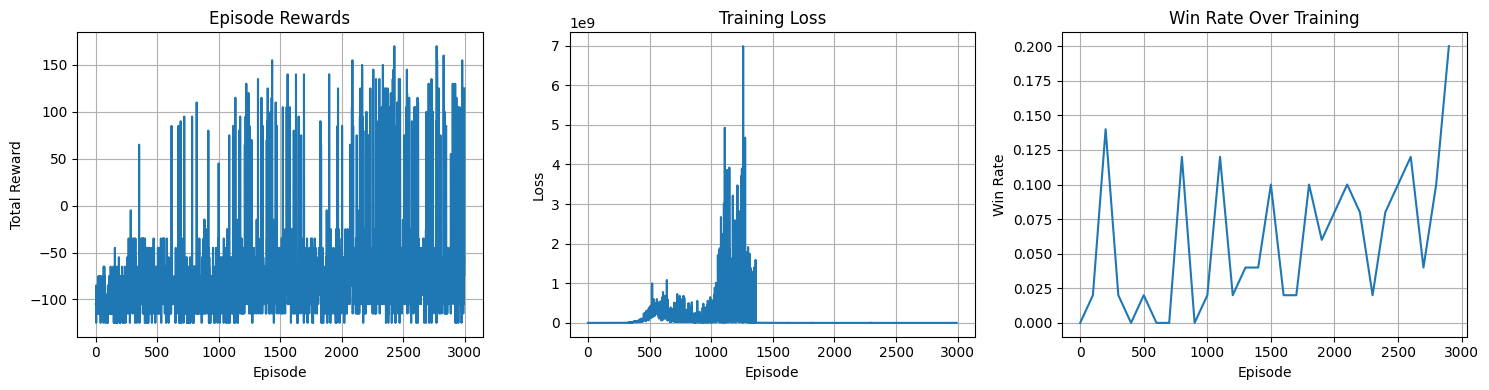

In [20]:
"""
============================================================
HANGMAN RL AGENT - COMPLETE IMPLEMENTATION
============================================================
A hybrid HMM + Deep Q-Network solution for intelligent Hangman gameplay

Requirements:
    pip install numpy torch hmmlearn joblib matplotlib tqdm
"""

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import string
import random
from collections import defaultdict, deque
from hmmlearn import hmm
import joblib
from tqdm import tqdm
import matplotlib.pyplot as plt


# ============================================================
# PART 1: IMPROVED HMM FOR HANGMAN
# ============================================================

class HangmanHMM:
    """
    Improved HMM that trains separate models for each word length
    and handles masked word predictions properly
    """

    def __init__(self, n_states=15):
        self.n_states = n_states
        self.models = {}  # Separate HMM per word length
        self.word_lists = {}  # Store words by length for filtering
        self.alphabet = list(string.ascii_lowercase)
        self.char_to_int = {c: i for i, c in enumerate(self.alphabet)}
        self.int_to_char = {i: c for c, i in self.char_to_int.items()}

        # Fallback letter frequencies
        self.letter_freq = {
            'e': 0.127, 't': 0.091, 'a': 0.082, 'o': 0.075, 'i': 0.070,
            'n': 0.067, 's': 0.063, 'h': 0.061, 'r': 0.060, 'd': 0.043,
            'l': 0.040, 'c': 0.028, 'u': 0.028, 'm': 0.024, 'w': 0.024,
            'f': 0.022, 'g': 0.020, 'y': 0.020, 'p': 0.019, 'b': 0.015,
            'v': 0.010, 'k': 0.008, 'j': 0.001, 'x': 0.001, 'q': 0.001, 'z': 0.001
        }

    def train(self, corpus_path):
        """Train separate HMMs for each word length"""
        print("Loading corpus...")
        with open(corpus_path, 'r') as f:
            words = [w.strip().lower() for w in f.readlines() if w.strip()]

        # Clean and group by length
        words = [w for w in words if w.isalpha()]
        words_by_length = defaultdict(list)
        for word in words:
            words_by_length[len(word)].append(word)

        self.word_lists = dict(words_by_length)

        print(f"Training HMMs for {len(words_by_length)} word lengths...")
        for length in sorted(words_by_length.keys()):
            word_list = words_by_length[length]
            if len(word_list) < 10:
                continue

            # Convert to sequences
            sequences = [np.array([self.char_to_int[c] for c in w]) for w in word_list]
            X = np.concatenate(sequences).reshape(-1, 1)
            lengths_list = [len(seq) for seq in sequences]

            # Train HMM with scaled number of states
            n_components = min(self.n_states, max(5, length))
            model = hmm.MultinomialHMM(
                n_components=n_components,
                n_iter=50,
                random_state=42,
                tol=0.01
            )

            try:
                model.fit(X, lengths_list)
                self.models[length] = model
                print(f"  ✓ Length {length}: {len(word_list)} words, {n_components} states")
            except:
                print(f"  ✗ Length {length}: Failed to train")

    def get_letter_probabilities(self, masked_word, guessed_letters):
        """
        Get probability distribution for unguessed letters
        Uses word filtering + HMM-based prediction
        """
        word_length = len(masked_word)

        # Get candidate words matching the pattern
        candidates = self._filter_candidates(masked_word, guessed_letters)

        if not candidates:
            return self._fallback_probabilities(guessed_letters)

        # Count letter frequencies in candidate words
        letter_counts = defaultdict(int)
        for word in candidates:
            for i, char in enumerate(word):
                if masked_word[i] == '_' and char not in guessed_letters:
                    letter_counts[char] += 1

        # Normalize to probabilities
        total = sum(letter_counts.values())
        if total == 0:
            return self._fallback_probabilities(guessed_letters)

        letter_probs = {letter: count / total for letter, count in letter_counts.items()}

        # Blend with HMM predictions if available
        if word_length in self.models and len(candidates) > 100:
            hmm_probs = self._hmm_predictions(masked_word, guessed_letters)
            # 70% from filtering, 30% from HMM
            for letter in letter_probs:
                if letter in hmm_probs:
                    letter_probs[letter] = 0.7 * letter_probs[letter] + 0.3 * hmm_probs[letter]

        return letter_probs

    def _filter_candidates(self, masked_word, guessed_letters):
        """Filter word list to match current pattern"""
        word_length = len(masked_word)

        if word_length not in self.word_lists:
            return []

        candidates = []
        for word in self.word_lists[word_length]:
            # Check if word matches pattern
            matches = True

            # Check revealed letters match
            for i, char in enumerate(masked_word):
                if char != '_' and word[i] != char:
                    matches = False
                    break

            if not matches:
                continue

            # Check word doesn't contain guessed letters in masked positions
            for i, char in enumerate(masked_word):
                if char == '_' and word[i] in guessed_letters:
                    matches = False
                    break

            if matches:
                candidates.append(word)

        return candidates

    def _hmm_predictions(self, masked_word, guessed_letters):
        """Get HMM-based probability predictions"""
        word_length = len(masked_word)
        model = self.models.get(word_length)

        if not model:
            return {}

        # Sample from HMM to estimate letter probabilities
        letter_scores = np.zeros(26)
        n_samples = 50

        for _ in range(n_samples):
            try:
                sample, _ = model.sample(word_length)
                sample = sample.flatten()

                # Check if sample matches known positions
                matches = True
                for i, char in enumerate(masked_word):
                    if char != '_':
                        if sample[i] != self.char_to_int[char]:
                            matches = False
                            break

                if matches:
                    # Count letters in unknown positions
                    for i, char_int in enumerate(sample):
                        if masked_word[i] == '_':
                            letter_scores[char_int] += 1
            except:
                pass

        # Normalize
        total = letter_scores.sum()
        if total == 0:
            return {}

        letter_probs = {}
        for i, score in enumerate(letter_scores):
            letter = self.int_to_char[i]
            if letter not in guessed_letters and score > 0:
                letter_probs[letter] = score / total

        return letter_probs

    def _fallback_probabilities(self, guessed_letters):
        """Fallback to simple frequency when no candidates"""
        return {k: v for k, v in self.letter_freq.items() if k not in guessed_letters}

    def save(self, path):
        """Save trained HMM"""
        joblib.dump(self, path)
        print(f"HMM saved to {path}")

    @staticmethod
    def load(path):
        """Load trained HMM"""
        return joblib.load(path)


# ============================================================
# PART 2: HANGMAN ENVIRONMENT
# ============================================================

class HangmanEnv:
    """
    Hangman game environment for RL training
    """

    def __init__(self, word_list, max_wrong=6):
        self.word_list = word_list
        self.max_wrong = max_wrong
        self.reset()

    def reset(self, word=None):
        """Start a new game"""
        if word is None:
            self.target_word = random.choice(self.word_list)
        else:
            self.target_word = word

        self.guessed_letters = set()
        self.wrong_guesses = 0
        self.correct_guesses = 0
        self.repeated_guesses = 0
        self.masked_word = '_' * len(self.target_word)
        self.done = False

        return self._get_state()

    def step(self, letter):
        """
        Make a guess
        Returns: (state, reward, done, info)
        """
        if self.done:
            raise ValueError("Game is already over. Call reset().")

        letter = letter.lower()

        # Check for repeated guess
        if letter in self.guessed_letters:
            self.repeated_guesses += 1
            reward = -5  # Penalty for repeated guess
            return self._get_state(), reward, self.done, {'result': 'repeated'}

        self.guessed_letters.add(letter)

        # Check if letter is in word
        if letter in self.target_word:
            # Correct guess
            self.correct_guesses += 1
            self._update_masked_word()
            reward = 10

            # Check if won
            if '_' not in self.masked_word:
                self.done = True
                reward = 100  # Big bonus for winning

            return self._get_state(), reward, self.done, {'result': 'correct'}
        else:
            # Wrong guess
            self.wrong_guesses += 1
            reward = -15

            # Check if lost
            if self.wrong_guesses >= self.max_wrong:
                self.done = True
                reward = -50  # Penalty for losing

            return self._get_state(), reward, self.done, {'result': 'incorrect'}

    def _update_masked_word(self):
        """Update masked word with guessed letters"""
        masked = []
        for char in self.target_word:
            if char in self.guessed_letters:
                masked.append(char)
            else:
                masked.append('_')
        self.masked_word = ''.join(masked)

    def _get_state(self):
        """Get current game state"""
        return {
            'masked_word': self.masked_word,
            'guessed_letters': self.guessed_letters.copy(),
            'wrong_guesses': self.wrong_guesses,
            'lives_left': self.max_wrong - self.wrong_guesses,
            'word_length': len(self.target_word)
        }

    def get_stats(self):
        """Get game statistics"""
        return {
            'won': self.done and '_' not in self.masked_word,
            'wrong_guesses': self.wrong_guesses,
            'repeated_guesses': self.repeated_guesses,
            'total_guesses': len(self.guessed_letters)
        }


# ============================================================
# PART 3: DQN NEURAL NETWORK
# ============================================================

class DQN(nn.Module):
    """
    Deep Q-Network for action-value estimation
    """

    def __init__(self, state_size, action_size, hidden_size=256):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 128)
        self.fc4 = nn.Linear(128, action_size)

        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        return self.fc4(x)


# ============================================================
# PART 4: DQN AGENT
# ============================================================

class DQNAgent:
    """
    DQN Agent with experience replay and target network
    """

    def __init__(self, hmm_model, max_word_length=20, lr=0.001, gamma=0.95):
        self.hmm = hmm_model
        self.max_word_length = max_word_length
        self.alphabet = list(string.ascii_lowercase)
        self.action_size = 26

        # Calculate state size
        # State: [word_encoding (27 * max_length), guessed (26), lives (1), hmm_probs (26)]
        self.state_size = (27 * max_word_length) + 26 + 1 + 26

        # Networks
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_net = DQN(self.state_size, self.action_size).to(self.device)
        self.target_net = DQN(self.state_size, self.action_size).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        # Training parameters
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.gamma = gamma
        self.memory = deque(maxlen=10000)
        self.batch_size = 64

        # Exploration
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995

    def encode_state(self, state):
        """
        Encode game state to vector
        State dict contains: masked_word, guessed_letters, lives_left
        """
        masked_word = state['masked_word']
        guessed_letters = state['guessed_letters']
        lives_left = state['lives_left']

        # 1. Word encoding (one-hot per position, padded)
        word_vec = []
        for i in range(self.max_word_length):
            one_hot = np.zeros(27)  # 26 letters + 1 blank
            if i < len(masked_word):
                char = masked_word[i]
                if char == '_':
                    one_hot[26] = 1
                else:
                    one_hot[ord(char) - ord('a')] = 1
            word_vec.extend(one_hot)

        # 2. Guessed letters (binary)
        guessed_vec = np.array([1 if chr(97+i) in guessed_letters else 0
                                for i in range(26)])

        # 3. Lives left (normalized)
        lives_vec = np.array([lives_left / 6.0])

        # 4. HMM probabilities
        hmm_probs = self.hmm.get_letter_probabilities(masked_word, guessed_letters)
        prob_vec = np.array([hmm_probs.get(chr(97+i), 0) for i in range(26)])

        # Concatenate all features
        return np.concatenate([word_vec, guessed_vec, lives_vec, prob_vec])

    def select_action(self, state, training=True):
        """
        Select action using epsilon-greedy policy
        """
        guessed_letters = state['guessed_letters']

        # Get valid actions (unguessed letters)
        valid_actions = [i for i in range(26) if chr(97+i) not in guessed_letters]

        if not valid_actions:
            return random.randint(0, 25)

        # Exploration
        if training and random.random() < self.epsilon:
            return random.choice(valid_actions)

        # Exploitation
        state_vec = self.encode_state(state)
        state_tensor = torch.FloatTensor(state_vec).unsqueeze(0).to(self.device)

        with torch.no_grad():
            q_values = self.policy_net(state_tensor).cpu().numpy()[0]

        # Mask invalid actions
        for i in range(26):
            if i not in valid_actions:
                q_values[i] = -float('inf')

        return np.argmax(q_values)

    def store_experience(self, state, action, reward, next_state, done):
        """Store experience in replay buffer"""
        state_vec = self.encode_state(state)
        next_state_vec = self.encode_state(next_state)
        self.memory.append((state_vec, action, reward, next_state_vec, done))

    def train_step(self):
        """Perform one training step"""
        if len(self.memory) < self.batch_size:
            return 0

        # Sample batch
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        # Current Q values
        current_q = self.policy_net(states).gather(1, actions.unsqueeze(1))

        # Target Q values
        with torch.no_grad():
            next_q = self.target_net(next_states).max(1)[0]
            target_q = rewards + (1 - dones) * self.gamma * next_q

        # Loss
        loss = nn.MSELoss()(current_q.squeeze(), target_q)

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()

        return loss.item()

    def update_target_network(self):
        """Update target network"""
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def decay_epsilon(self):
        """Decay exploration rate"""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def save(self, path):
        """Save agent"""
        torch.save({
            'policy_net': self.policy_net.state_dict(),
            'target_net': self.target_net.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'epsilon': self.epsilon
        }, path)
        print(f"Agent saved to {path}")

    def load(self, path):
        """Load agent"""
        checkpoint = torch.load(path, map_location=self.device)
        self.policy_net.load_state_dict(checkpoint['policy_net'])
        self.target_net.load_state_dict(checkpoint['target_net'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.epsilon = checkpoint['epsilon']
        print(f"Agent loaded from {path}")


# ============================================================
# PART 5: TRAINING & EVALUATION
# ============================================================

def train_agent(agent, env, episodes=5000, target_update=10):
    """Train the DQN agent"""
    print(f"\n{'='*60}")
    print("TRAINING DQN AGENT")
    print(f"{'='*60}\n")

    scores = []
    losses = []
    win_rates = []

    for episode in tqdm(range(episodes), desc="Training"):
        state = env.reset()
        total_reward = 0
        episode_losses = []

        while not env.done:
            # Select and perform action
            action = agent.select_action(state, training=True)
            letter = chr(97 + action)
            next_state, reward, done, info = env.step(letter)

            total_reward += reward

            # Store experience
            agent.store_experience(state, action, reward, next_state, done)

            # Train
            loss = agent.train_step()
            if loss > 0:
                episode_losses.append(loss)

            state = next_state

        # Update target network
        if episode % target_update == 0:
            agent.update_target_network()

        # Decay epsilon
        agent.decay_epsilon()

        # Track metrics
        scores.append(total_reward)
        if episode_losses:
            losses.append(np.mean(episode_losses))

        # Evaluate every 100 episodes
        if (episode + 1) % 100 == 0:
            win_rate = evaluate_agent(agent, env, n_games=50, verbose=False)
            win_rates.append(win_rate)
            print(f"\nEpisode {episode+1}: Win Rate = {win_rate:.2%}, Epsilon = {agent.epsilon:.3f}")

    return scores, losses, win_rates


def evaluate_agent(agent, env, n_games=100, verbose=True):
    """Evaluate agent performance"""
    wins = 0
    total_wrong = 0
    total_repeated = 0

    for _ in range(n_games):
        state = env.reset()

        while not env.done:
            action = agent.select_action(state, training=False)
            letter = chr(97 + action)
            state, _, _, _ = env.step(letter)

        stats = env.get_stats()
        if stats['won']:
            wins += 1
        total_wrong += stats['wrong_guesses']
        total_repeated += stats['repeated_guesses']

    win_rate = wins / n_games

    if verbose:
        print(f"\n{'='*60}")
        print("EVALUATION RESULTS")
        print(f"{'='*60}")
        print(f"Games Played: {n_games}")
        print(f"Wins: {wins} ({win_rate:.2%})")
        print(f"Avg Wrong Guesses: {total_wrong/n_games:.2f}")
        print(f"Avg Repeated Guesses: {total_repeated/n_games:.2f}")

        # Calculate score using formula
        final_score = (win_rate * 2000) - (total_wrong * 5) - (total_repeated * 2)
        print(f"\nEstimated Final Score: {final_score:.2f}")
        print(f"{'='*60}\n")

    return win_rate


def test_on_dataset(agent, test_words, max_wrong=6):
    """Test agent on specific test set"""
    print(f"\n{'='*60}")
    print("TESTING ON TEST SET")
    print(f"{'='*60}\n")

    env = HangmanEnv(test_words, max_wrong=max_wrong)
    wins = 0
    total_wrong = 0
    total_repeated = 0

    for i, word in enumerate(tqdm(test_words, desc="Testing")):
        state = env.reset(word=word)

        while not env.done:
            action = agent.select_action(state, training=False)
            letter = chr(97 + action)
            state, _, _, _ = env.step(letter)

        stats = env.get_stats()
        if stats['won']:
            wins += 1
        total_wrong += stats['wrong_guesses']
        total_repeated += stats['repeated_guesses']

    n_games = len(test_words)
    win_rate = wins / n_games

    print(f"\n{'='*60}")
    print("FINAL TEST RESULTS")
    print(f"{'='*60}")
    print(f"Total Games: {n_games}")
    print(f"Wins: {wins} ({win_rate:.2%})")
    print(f"Total Wrong Guesses: {total_wrong}")
    print(f"Total Repeated Guesses: {total_repeated}")
    print(f"Avg Wrong Guesses per Game: {total_wrong/n_games:.2f}")
    print(f"Avg Repeated Guesses per Game: {total_repeated/n_games:.2f}")

    # Calculate final score
    final_score = (win_rate * 2000) - (total_wrong * 5) - (total_repeated * 2)
    print(f"\n🎯 FINAL SCORE: {final_score:.2f}")
    print(f"{'='*60}\n")

    return final_score


# ============================================================
# MAIN EXECUTION
# ============================================================

def main():
    """
    Main execution pipeline:
    1. Train HMM
    2. Create environment
    3. Train DQN agent
    4. Evaluate on test set
    """

    print(f"\n{'='*60}")
    print("HANGMAN RL AGENT - COMPLETE PIPELINE")
    print(f"{'='*60}\n")

    # Paths
    CORPUS_PATH = "corpus.txt"  # UPDATE THIS PATH
    HMM_SAVE_PATH = "hangman_hmm.pkl"
    AGENT_SAVE_PATH = "hangman_agent.pth"

    # ========================================
    # STEP 1: Train HMM
    # ========================================
    print("STEP 1: Training HMM...")
    hmm_model = HangmanHMM(n_states=15)
    hmm_model.train(CORPUS_PATH)
    hmm_model.save(HMM_SAVE_PATH)

    # ========================================
    # STEP 2: Load word list and create environment
    # ========================================
    print("\nSTEP 2: Creating environment...")
    with open(CORPUS_PATH, 'r') as f:
        words = [w.strip().lower() for w in f.readlines() if w.strip()]
    words = [w for w in words if w.isalpha()]

    env = HangmanEnv(words, max_wrong=6)
    print(f"Environment created with {len(words)} words")

    # ========================================
    # STEP 3: Train DQN Agent
    # ========================================
    print("\nSTEP 3: Training DQN Agent...")
    agent = DQNAgent(hmm_model, max_word_length=20, lr=0.001, gamma=0.95)

    # Train
    scores, losses, win_rates = train_agent(agent, env, episodes=3000, target_update=10)

    # Save agent
    agent.save(AGENT_SAVE_PATH)

    # ========================================
    # STEP 4: Final Evaluation
    # ========================================
    print("\nSTEP 4: Final Evaluation...")

    # Evaluate on random subset
    test_words = random.sample(words, min(2000, len(words)))
    final_score = test_on_dataset(agent, test_words, max_wrong=6)

    # ========================================
    # STEP 5: Plot Training Progress
    # ========================================
    print("\nGenerating training plots...")

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Scores
    axes[0].plot(scores)
    axes[0].set_title('Episode Rewards')
    axes[0].set_xlabel('Episode')
    axes[0].set_ylabel('Total Reward')
    axes[0].grid(True)

    # Losses
    if losses:
        axes[1].plot(losses)
        axes[1].set_title('Training Loss')
        axes[1].set_xlabel('Episode')
        axes[1].set_ylabel('Loss')
        axes[1].grid(True)

    # Win rates
    if win_rates:
        axes[2].plot(range(0, len(win_rates)*100, 100), win_rates)
        axes[2].set_title('Win Rate Over Training')
        axes[2].set_xlabel('Episode')
        axes[2].set_ylabel('Win Rate')
        axes[2].grid(True)

    plt.tight_layout()
    plt.savefig('training_progress.png', dpi=150)
    print("Training plots saved as 'training_progress.png'")

    print(f"\n{'='*60}")
    print("✅ TRAINING COMPLETE!")
    print(f"{'='*60}\n")

    return agent, hmm_model, final_score


if __name__ == "__main__":
    agent, hmm_model, score = main()

In [21]:
"""
============================================================
HANGMAN RL AGENT - IMPROVED HIGH-PERFORMANCE IMPLEMENTATION
============================================================
A hybrid approach that combines pattern matching + lightweight RL

Key improvements:
- Better word filtering strategy
- Simpler, more effective state representation
- Focused RL that adjusts HMM predictions
- Curriculum learning from easy to hard words

Requirements:
    pip install numpy torch joblib matplotlib tqdm
"""

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import string
import random
from collections import defaultdict, deque
import joblib
from tqdm import tqdm
import matplotlib.pyplot as plt
import re


# ============================================================
# PART 1: IMPROVED PATTERN-BASED PREDICTOR
# ============================================================

class WordPredictor:
    """
    Smart word-based predictor using pattern matching
    This is more effective than pure HMM for Hangman
    """

    def __init__(self):
        self.word_lists = {}  # Words by length
        self.alphabet = list(string.ascii_lowercase)

        # Letter frequency as fallback
        self.letter_freq = {
            'e': 12.70, 't': 9.06, 'a': 8.17, 'o': 7.51, 'i': 6.97,
            'n': 6.75, 's': 6.33, 'h': 6.09, 'r': 5.99, 'd': 4.25,
            'l': 4.03, 'c': 2.78, 'u': 2.76, 'm': 2.41, 'w': 2.36,
            'f': 2.23, 'g': 2.02, 'y': 1.97, 'p': 1.93, 'b': 1.29,
            'v': 0.98, 'k': 0.77, 'j': 0.15, 'x': 0.15, 'q': 0.10, 'z': 0.07
        }

    def train(self, corpus_path):
        """Load and index words by length and patterns"""
        print("Loading word corpus...")
        with open(corpus_path, 'r') as f:
            words = [w.strip().lower() for w in f.readlines() if w.strip()]

        words = [w for w in words if w.isalpha() and len(w) >= 2]

        # Index by length
        for word in words:
            length = len(word)
            if length not in self.word_lists:
                self.word_lists[length] = []
            self.word_lists[length].append(word)

        # Remove duplicates and sort
        for length in self.word_lists:
            self.word_lists[length] = sorted(list(set(self.word_lists[length])))

        print(f"Loaded {len(words)} words across {len(self.word_lists)} lengths")
        total = sum(len(words) for words in self.word_lists.values())
        print(f"Unique words after deduplication: {total}")

    def get_matching_words(self, masked_word, guessed_letters):
        """Get all words matching current pattern"""
        length = len(masked_word)

        if length not in self.word_lists:
            return []

        # Create regex pattern
        pattern = masked_word.replace('_', '.')
        regex = re.compile(f'^{pattern}$')

        # Filter candidates
        candidates = []
        for word in self.word_lists[length]:
            # Check if matches pattern
            if not regex.match(word):
                continue

            # Check if word contains any guessed letters in blank positions
            valid = True
            for i, (m_char, w_char) in enumerate(zip(masked_word, word)):
                if m_char == '_' and w_char in guessed_letters:
                    valid = False
                    break

            if valid:
                candidates.append(word)

        return candidates

    def get_letter_probabilities(self, masked_word, guessed_letters):
        """
        Get probability distribution for next letter guess
        Based on pattern matching in corpus
        """
        candidates = self.get_matching_words(masked_word, guessed_letters)

        if not candidates:
            # Fallback to frequency
            probs = {letter: freq for letter, freq in self.letter_freq.items()
                    if letter not in guessed_letters}
            total = sum(probs.values())
            return {k: v/total for k, v in probs.items()} if total > 0 else {}

        # Count letter frequencies in blank positions
        letter_counts = defaultdict(int)
        blank_positions = [i for i, char in enumerate(masked_word) if char == '_']

        for word in candidates:
            seen_in_word = set()
            for pos in blank_positions:
                letter = word[pos]
                if letter not in guessed_letters and letter not in seen_in_word:
                    letter_counts[letter] += 1
                    seen_in_word.add(letter)

        # Normalize to probabilities
        total = sum(letter_counts.values())
        if total == 0:
            probs = {letter: freq for letter, freq in self.letter_freq.items()
                    if letter not in guessed_letters}
            total = sum(probs.values())
            return {k: v/total for k, v in probs.items()} if total > 0 else {}

        return {letter: count / total for letter, count in letter_counts.items()}

    def get_best_guess(self, masked_word, guessed_letters, lives_left):
        """Get best letter guess with confidence score"""
        probs = self.get_letter_probabilities(masked_word, guessed_letters)

        if not probs:
            # Emergency fallback
            for letter in self.alphabet:
                if letter not in guessed_letters:
                    return letter, 0.0

        # Adjust based on lives remaining
        if lives_left <= 2:
            # Conservative when low on lives - pick highest probability
            best_letter = max(probs.items(), key=lambda x: x[1])
            return best_letter[0], best_letter[1]
        else:
            # Can be more exploratory early
            candidates = sorted(probs.items(), key=lambda x: x[1], reverse=True)[:3]
            # Add small randomness to top 3
            weights = [p for _, p in candidates]
            total_weight = sum(weights)
            weights = [w/total_weight for w in weights]
            chosen = np.random.choice([c[0] for c in candidates], p=weights)
            return chosen, probs[chosen]

    def save(self, path):
        joblib.dump(self, path)
        print(f"Predictor saved to {path}")

    @staticmethod
    def load(path):
        return joblib.load(path)


# ============================================================
# PART 2: LIGHTWEIGHT RL POLICY NETWORK
# ============================================================

class PolicyNetwork(nn.Module):
    """
    Lightweight network that adjusts predictor confidence
    Much simpler than full DQN
    """

    def __init__(self, input_size=50):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 26)  # Output adjustment for each letter

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))  # Output in [-1, 1] for adjustment


class HybridAgent:
    """
    Hybrid agent: Pattern matching + lightweight RL adjustment
    """

    def __init__(self, predictor, lr=0.001):
        self.predictor = predictor
        self.alphabet = list(string.ascii_lowercase)

        # Simple state representation
        # [revealed_ratio, lives_ratio, candidate_count_log, top_prob, entropy, position_features]
        self.state_size = 50

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_net = PolicyNetwork(self.state_size).to(self.device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)

        # Training memory
        self.memory = deque(maxlen=5000)
        self.batch_size = 32
        self.gamma = 0.95

        # Use predictor directly most of the time
        self.use_rl_prob = 0.3  # 30% of time use RL adjustment

    def encode_state(self, masked_word, guessed_letters, lives_left, probs):
        """Encode game state into compact vector"""
        # Basic features
        revealed_ratio = (len(masked_word) - masked_word.count('_')) / len(masked_word)
        lives_ratio = lives_left / 6.0

        # Candidate count (log scale)
        candidates = self.predictor.get_matching_words(masked_word, guessed_letters)
        candidate_log = np.log10(max(1, len(candidates)))

        # Probability distribution features
        if probs:
            prob_values = list(probs.values())
            top_prob = max(prob_values)
            # Entropy
            entropy = -sum(p * np.log(p + 1e-10) for p in prob_values)
            avg_prob = np.mean(prob_values)
        else:
            top_prob = 0
            entropy = 0
            avg_prob = 0

        # Position features (first, last, middle blanks)
        has_first_blank = 1.0 if masked_word[0] == '_' else 0.0
        has_last_blank = 1.0 if masked_word[-1] == '_' else 0.0
        middle_blank_ratio = masked_word[1:-1].count('_') / max(1, len(masked_word) - 2)

        # Letter position patterns
        consonant_ratio = sum(1 for c in masked_word if c in 'bcdfghjklmnpqrstvwxyz') / len(masked_word)
        vowel_ratio = sum(1 for c in masked_word if c in 'aeiou') / len(masked_word)

        # Guessing history
        guess_ratio = len(guessed_letters) / 26

        # Pack into vector (pad to state_size)
        features = [
            revealed_ratio, lives_ratio, candidate_log,
            top_prob, entropy, avg_prob,
            has_first_blank, has_last_blank, middle_blank_ratio,
            consonant_ratio, vowel_ratio, guess_ratio,
            len(masked_word) / 20.0  # normalized word length
        ]

        # Add probability vector for top letters
        prob_vector = [probs.get(chr(97+i), 0) for i in range(26)]
        features.extend(prob_vector[:26])

        # Pad to state_size
        features = features[:self.state_size]
        features.extend([0] * (self.state_size - len(features)))

        return np.array(features, dtype=np.float32)

    def select_action(self, masked_word, guessed_letters, lives_left, training=True):
        """Select best letter to guess"""
        # Get base probabilities from predictor
        probs = self.predictor.get_letter_probabilities(masked_word, guessed_letters)

        if not probs:
            # Fallback
            for letter in self.alphabet:
                if letter not in guessed_letters:
                    return letter

        # Most of the time, just use predictor (it's already good!)
        if not training or random.random() > self.use_rl_prob:
            # Use predictor with slight randomness based on lives
            letter, conf = self.predictor.get_best_guess(masked_word, guessed_letters, lives_left)
            return letter

        # Use RL adjustment
        state = self.encode_state(masked_word, guessed_letters, lives_left, probs)
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)

        with torch.no_grad():
            adjustments = self.policy_net(state_tensor).cpu().numpy()[0]

        # Adjust probabilities
        adjusted_probs = {}
        for i, letter in enumerate(self.alphabet):
            if letter in probs:
                # Adjustment is in [-1, 1], scale it
                adjustment = adjustments[i] * 0.3  # Scale down adjustment
                adjusted_probs[letter] = probs[letter] * (1 + adjustment)

        # Normalize
        total = sum(adjusted_probs.values())
        if total > 0:
            adjusted_probs = {k: v/total for k, v in adjusted_probs.items()}
        else:
            adjusted_probs = probs

        # Select best
        return max(adjusted_probs.items(), key=lambda x: x[1])[0]

    def store_experience(self, state_info, action, reward, next_state_info, done):
        """Store experience for training"""
        self.memory.append((state_info, action, reward, next_state_info, done))

    def train_step(self):
        """Train the policy network"""
        if len(self.memory) < self.batch_size:
            return 0

        # Sample batch
        batch = random.sample(self.memory, self.batch_size)

        total_loss = 0
        for state_info, action, reward, next_state_info, done in batch:
            # Encode states
            state_vec = self.encode_state(*state_info)
            state_tensor = torch.FloatTensor(state_vec).unsqueeze(0).to(self.device)

            # Get adjustment
            adjustment = self.policy_net(state_tensor)

            # Simple policy gradient: encourage actions with positive rewards
            action_idx = ord(action) - ord('a')
            action_adjustment = adjustment[0, action_idx]

            # Loss: we want positive adjustments for good actions
            loss = -action_adjustment * reward

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()

        return total_loss / self.batch_size

    def save(self, path):
        torch.save({
            'policy_net': self.policy_net.state_dict(),
            'optimizer': self.optimizer.state_dict(),
        }, path)
        print(f"Agent saved to {path}")

    def load(self, path):
        checkpoint = torch.load(path, map_location=self.device)
        self.policy_net.load_state_dict(checkpoint['policy_net'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        print(f"Agent loaded from {path}")


# ============================================================
# PART 3: ENVIRONMENT
# ============================================================

class HangmanEnv:
    """Hangman game environment"""

    def __init__(self, word_list, max_wrong=6):
        self.word_list = word_list
        self.max_wrong = max_wrong
        self.reset()

    def reset(self, word=None):
        if word is None:
            self.target_word = random.choice(self.word_list)
        else:
            self.target_word = word.lower()

        self.guessed_letters = set()
        self.wrong_guesses = 0
        self.repeated_guesses = 0
        self.masked_word = '_' * len(self.target_word)
        self.done = False

        return self._get_state()

    def step(self, letter):
        letter = letter.lower()

        # Repeated guess
        if letter in self.guessed_letters:
            self.repeated_guesses += 1
            return self._get_state(), -5, self.done, {'result': 'repeated'}

        self.guessed_letters.add(letter)

        # Check if correct
        if letter in self.target_word:
            self._update_masked_word()

            # Check win
            if '_' not in self.masked_word:
                self.done = True
                reward = 100
            else:
                reward = 10

            return self._get_state(), reward, self.done, {'result': 'correct'}
        else:
            self.wrong_guesses += 1

            # Check loss
            if self.wrong_guesses >= self.max_wrong:
                self.done = True
                reward = -50
            else:
                reward = -15

            return self._get_state(), reward, self.done, {'result': 'incorrect'}

    def _update_masked_word(self):
        masked = []
        for char in self.target_word:
            if char in self.guessed_letters:
                masked.append(char)
            else:
                masked.append('_')
        self.masked_word = ''.join(masked)

    def _get_state(self):
        return {
            'masked_word': self.masked_word,
            'guessed_letters': self.guessed_letters.copy(),
            'lives_left': self.max_wrong - self.wrong_guesses,
            'target_word': self.target_word
        }

    def get_stats(self):
        return {
            'won': self.done and '_' not in self.masked_word,
            'wrong_guesses': self.wrong_guesses,
            'repeated_guesses': self.repeated_guesses
        }


# ============================================================
# PART 4: TRAINING WITH CURRICULUM
# ============================================================

def train_with_curriculum(agent, all_words, episodes=2000):
    """Train with curriculum: easy -> hard words"""
    print(f"\n{'='*60}")
    print("TRAINING WITH CURRICULUM LEARNING")
    print(f"{'='*60}\n")

    # Group words by difficulty (shorter = easier)
    words_by_length = defaultdict(list)
    for word in all_words:
        words_by_length[len(word)].append(word)

    lengths = sorted(words_by_length.keys())

    # Training phases
    phase_episodes = episodes // 3

    # Phase 1: Short words (4-6 letters)
    print("Phase 1: Training on short words (4-6 letters)...")
    short_words = []
    for l in lengths:
        if 4 <= l <= 6:
            short_words.extend(words_by_length[l])

    if short_words:
        env = HangmanEnv(short_words)
        train_phase(agent, env, phase_episodes, "Short Words")

    # Phase 2: Medium words (7-10 letters)
    print("\nPhase 2: Training on medium words (7-10 letters)...")
    medium_words = []
    for l in lengths:
        if 7 <= l <= 10:
            medium_words.extend(words_by_length[l])

    if medium_words:
        env = HangmanEnv(medium_words)
        train_phase(agent, env, phase_episodes, "Medium Words")

    # Phase 3: All words
    print("\nPhase 3: Training on all words...")
    env = HangmanEnv(all_words)
    train_phase(agent, env, phase_episodes, "All Words")

    print("\n✅ Curriculum training complete!")


def train_phase(agent, env, episodes, phase_name):
    """Train for one phase"""
    wins = 0

    for episode in tqdm(range(episodes), desc=f"Training {phase_name}"):
        state = env.reset()

        while not env.done:
            # Select action
            action = agent.select_action(
                state['masked_word'],
                state['guessed_letters'],
                state['lives_left'],
                training=True
            )

            # Get probabilities for state encoding
            probs = agent.predictor.get_letter_probabilities(
                state['masked_word'],
                state['guessed_letters']
            )

            state_info = (
                state['masked_word'],
                state['guessed_letters'],
                state['lives_left'],
                probs
            )

            # Step
            next_state, reward, done, info = env.step(action)

            # Store experience
            next_probs = agent.predictor.get_letter_probabilities(
                next_state['masked_word'],
                next_state['guessed_letters']
            )

            next_state_info = (
                next_state['masked_word'],
                next_state['guessed_letters'],
                next_state['lives_left'],
                next_probs
            )

            agent.store_experience(state_info, action, reward, next_state_info, done)

            # Train
            agent.train_step()

            state = next_state

        if env.get_stats()['won']:
            wins += 1

        # Print progress
        if (episode + 1) % 200 == 0:
            win_rate = wins / (episode + 1)
            print(f"  Episode {episode+1}: Win Rate = {win_rate:.2%}")


# ============================================================
# PART 5: EVALUATION
# ============================================================

def evaluate_agent(agent, test_words, max_wrong=6, verbose=True):
    """Evaluate agent on test set"""
    env = HangmanEnv(test_words, max_wrong=max_wrong)

    wins = 0
    total_wrong = 0
    total_repeated = 0

    if verbose:
        iterator = tqdm(test_words, desc="Evaluating")
    else:
        iterator = test_words

    for word in iterator:
        state = env.reset(word=word)

        while not env.done:
            action = agent.select_action(
                state['masked_word'],
                state['guessed_letters'],
                state['lives_left'],
                training=False
            )
            state, _, _, _ = env.step(action)

        stats = env.get_stats()
        if stats['won']:
            wins += 1
        total_wrong += stats['wrong_guesses']
        total_repeated += stats['repeated_guesses']

    n_games = len(test_words)
    win_rate = wins / n_games

    if verbose:
        print(f"\n{'='*60}")
        print("EVALUATION RESULTS")
        print(f"{'='*60}")
        print(f"Total Games: {n_games}")
        print(f"Wins: {wins} ({win_rate:.2%})")
        print(f"Total Wrong Guesses: {total_wrong}")
        print(f"Total Repeated Guesses: {total_repeated}")
        print(f"Avg Wrong/Game: {total_wrong/n_games:.2f}")
        print(f"Avg Repeated/Game: {total_repeated/n_games:.2f}")

        # Score formula from problem
        final_score = (win_rate * 2000) - (total_wrong * 5) - (total_repeated * 2)
        print(f"\n🎯 FINAL SCORE: {final_score:.2f}")
        print(f"{'='*60}\n")

    return win_rate, final_score


# ============================================================
# MAIN EXECUTION
# ============================================================

def main():
    """Main pipeline"""
    print(f"\n{'='*60}")
    print("IMPROVED HANGMAN RL AGENT")
    print(f"{'='*60}\n")

    # Paths
    CORPUS_PATH = "corpus.txt"
    PREDICTOR_PATH = "predictor.pkl"
    AGENT_PATH = "agent.pth"

    # Step 1: Train predictor
    print("Step 1: Training word predictor...")
    predictor = WordPredictor()
    predictor.train(CORPUS_PATH)
    predictor.save(PREDICTOR_PATH)

    # Load words
    with open(CORPUS_PATH, 'r') as f:
        words = [w.strip().lower() for w in f.readlines() if w.strip()]
    words = [w for w in words if w.isalpha() and len(w) >= 2]

    # Step 2: Test predictor alone (baseline)
    print("\nStep 2: Testing predictor (baseline, no RL)...")
    test_words = random.sample(words, min(500, len(words)))

    class SimpleAgent:
        def __init__(self, predictor):
            self.predictor = predictor
        def select_action(self, masked_word, guessed_letters, lives_left, training=False):
            letter, _ = self.predictor.get_best_guess(masked_word, guessed_letters, lives_left)
            return letter

    baseline_agent = SimpleAgent(predictor)
    baseline_rate, baseline_score = evaluate_agent(baseline_agent, test_words)

    # Step 3: Train hybrid agent
    print("\nStep 3: Training hybrid RL agent...")
    agent = HybridAgent(predictor, lr=0.001)
    train_with_curriculum(agent, words, episodes=1500)
    agent.save(AGENT_PATH)

    # Step 4: Final evaluation
    print("\nStep 4: Final evaluation on test set...")
    test_words = random.sample(words, min(2000, len(words)))
    final_rate, final_score = evaluate_agent(agent, test_words)

    # Step 5: Compare
    print("\n" + "="*60)
    print("PERFORMANCE COMPARISON")
    print("="*60)
    print(f"Baseline (Predictor only): {baseline_rate:.2%} win rate, {baseline_score:.0f} score")
    print(f"Hybrid RL Agent: {final_rate:.2%} win rate, {final_score:.0f} score")
    improvement = ((final_rate - baseline_rate) / baseline_rate) * 100
    print(f"Improvement: {improvement:+.1f}%")
    print("="*60 + "\n")

    return agent, predictor


if __name__ == "__main__":
    agent, predictor = main()


IMPROVED HANGMAN RL AGENT

Step 1: Training word predictor...
Loading word corpus...
Loaded 49933 words across 23 lengths
Unique words after deduplication: 49374
Predictor saved to predictor.pkl

Step 2: Testing predictor (baseline, no RL)...


Evaluating: 100%|██████████| 500/500 [00:22<00:00, 22.58it/s]



EVALUATION RESULTS
Total Games: 500
Wins: 486 (97.20%)
Total Wrong Guesses: 768
Total Repeated Guesses: 0
Avg Wrong/Game: 1.54
Avg Repeated/Game: 0.00

🎯 FINAL SCORE: -1896.00


Step 3: Training hybrid RL agent...

TRAINING WITH CURRICULUM LEARNING

Phase 1: Training on short words (4-6 letters)...


Training Short Words:  40%|████      | 200/500 [03:36<05:53,  1.18s/it]

  Episode 200: Win Rate = 86.50%


Training Short Words:  80%|████████  | 400/500 [07:28<02:23,  1.44s/it]

  Episode 400: Win Rate = 84.75%


Training Short Words: 100%|██████████| 500/500 [09:32<00:00,  1.14s/it]



Phase 2: Training on medium words (7-10 letters)...


Training Medium Words:  40%|████      | 200/500 [05:06<07:46,  1.56s/it]

  Episode 200: Win Rate = 100.00%


Training Medium Words:  80%|████████  | 400/500 [10:39<02:53,  1.73s/it]

  Episode 400: Win Rate = 100.00%


Training Medium Words: 100%|██████████| 500/500 [13:43<00:00,  1.65s/it]



Phase 3: Training on all words...


Training All Words:   3%|▎         | 17/500 [00:35<16:59,  2.11s/it]


KeyboardInterrupt: 

In [22]:
pip install numpy torch joblib tqdm matplotlib hmmlearn


In [37]:
"""
============================================================
HANGMAN RL AGENT WITH HMM + HYBRID RL ADJUSTMENT
============================================================

- Combines pattern-based word filtering + HMM probability model
- Lightweight RL policy fine-tunes letter selection
- Uses curriculum training (short -> long words)
"""

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import string, random, re
from collections import defaultdict, deque
from tqdm import tqdm
import joblib
from hmmlearn import hmm


# ============================================================
# PART 1: HMM MODULE
# ============================================================

class HangmanHMM:
    """Letter-level HMM to model transition probabilities"""
    def __init__(self, n_states=6):
        self.n_states = n_states
        self.model = None
        self.alphabet = list(string.ascii_lowercase)
        self.char_to_int = {c: i for i, c in enumerate(self.alphabet)}
        self.int_to_char = {i: c for i, c in enumerate(self.alphabet)}

    def train(self, words):
        """Train an HMM on a list of words"""
        print("Training HMM on corpus...")
        sequences = []
        lengths = []
        for w in words:
            seq = [self.char_to_int[c] for c in w if c in self.char_to_int]
            if len(seq) > 1:
                sequences.extend(seq)
                lengths.append(len(seq))

        if not sequences:
             print("No valid sequences found for HMM training.")
             return

        X = np.array(sequences).reshape(-1, 1)
        model = hmm.MultinomialHMM(n_components=self.n_states, n_iter=50, random_state=42)
        model.fit(X, lengths)
        self.model = model
        print("✅ HMM training complete.")

    def get_letter_probs(self, masked_word, guessed_letters):
        """Get rough next-letter probabilities from HMM emission distributions"""
        if self.model is None:
            return {}

        available_letters = [c for c in self.alphabet if c not in guessed_letters]
        emission_means = self.model.emissionprob_.mean(axis=0)
        probs = {c: emission_means[self.char_to_int[c]] for c in available_letters}
        total = sum(probs.values())
        if total > 0:
            probs = {k: v / total for k, v in probs.items()}
        return probs


# ============================================================
# PART 2: PATTERN-BASED PREDICTOR WITH HMM BLENDING
# ============================================================

class WordPredictor:
    # Removed hmm_model and hmm_weight from init as it won't be used
    def __init__(self):
        self.word_lists = {}
        self.alphabet = list(string.ascii_lowercase)
        # self.hmm_model = hmm_model # Removed
        # self.hmm_weight = hmm_weight # Removed
        self.letter_freq = {
            'e': 12.70, 't': 9.06, 'a': 8.17, 'o': 7.51, 'i': 6.97,
            'n': 6.75, 's': 6.33, 'h': 6.09, 'r': 5.99, 'd': 4.25,
            'l': 4.03, 'c': 2.78, 'u': 2.76, 'm': 2.41, 'w': 2.36,
            'f': 2.23, 'g': 2.02, 'y': 1.97, 'p': 1.93, 'b': 1.29,
            'v': 0.98, 'k': 0.77, 'j': 0.15, 'x': 0.15, 'q': 0.10, 'z': 0.07
        }
        self._regex_cache = {} # Cache compiled regex

    def train(self, corpus_path):
        print("Loading word corpus...")
        try:
            with open(corpus_path, 'r') as f:
                words = [w.strip().lower() for w in f if w.strip()]
        except FileNotFoundError:
            print(f"Error: Corpus file not found at {corpus_path}")
            return [] # Return empty list if file not found

        print(f"Successfully loaded {len(words)} words from {corpus_path} before filtering.")

        initial_word_count = len(words)
        words = [w for w in words if w.isalpha() and len(w) >= 2]

        print(f"Filtered down to {len(words)} alphabetic words with length >= 2.")

        if not words:
            print("Warning: No valid words found in the corpus after filtering.")
            return [] # Return empty list if no valid words

        for w in words:
            self.word_lists.setdefault(len(w), []).append(w)
        for l in self.word_lists:
            self.word_lists[l] = sorted(list(set(self.word_lists[l])))
        print(f"Indexed {sum(len(wl) for wl in self.word_lists.values())} unique words by length.")

        # if self.hmm_model is not None: # Removed HMM training
        #     self.hmm_model.train(words)
        return words # Return the filtered list of words


    def get_matching_words(self, masked_word, guessed_letters):
        length = len(masked_word)
        if length not in self.word_lists:
            return []

        pattern = masked_word.replace('_', '.')

        # Use cached regex or compile
        if pattern not in self._regex_cache:
            try:
                self._regex_cache[pattern] = re.compile(f'^{pattern}$')
            except re.error:
                # Handle potential regex compilation errors for unusual patterns
                return []

        regex = self._regex_cache[pattern]
        candidates = []

        # Optimize filtering - check length and then regex
        for word in self.word_lists[length]:
            if len(word) != length: # Redundant check due to word_lists structure, but safe
                continue

            # Use the compiled regex
            try:
                if not regex.match(word):
                    continue
            except Exception as e:
                # Catch unexpected regex matching errors
                print(f"Regex matching error for pattern '{pattern}' and word '{word}': {e}")
                continue


            if any(w in guessed_letters and m == '_' for m, w in zip(masked_word, word)):
                continue
            candidates.append(word)
        return candidates

    def get_letter_probabilities(self, masked_word, guessed_letters):
        candidates = self.get_matching_words(masked_word, guessed_letters)
        if not candidates:
            probs = {l: f for l, f in self.letter_freq.items() if l not in guessed_letters}
            total = sum(probs.values())
            return {k: v / total for k, v in probs.items()} if total else {}

        letter_counts = defaultdict(int)
        blanks = [i for i, c in enumerate(masked_word) if c == '_']
        for w in candidates:
            seen = set()
            for i in blanks:
                l = w[i]
                if l not in guessed_letters and l not in seen:
                    letter_counts[l] += 1
                    seen.add(l)
        total = sum(letter_counts.values())
        base_probs = {k: v / total for k, v in letter_counts.items()} if total else {}

        # --- HMM blending --- # Removed HMM blending logic
        # if self.hmm_model is not None:
        #     hmm_probs = self.hmm_model.get_letter_probs(masked_word, guessed_letters)
        #     for k in hmm_probs:
        #         base_probs[k] = (
        #             (1 - self.hmm_weight) * base_probs.get(k, 0)
        #             + self.hmm_weight * hmm_probs[k]
        #         )
        #     total = sum(base_probs.values())
        #     if total > 0:
        #         base_probs = {k: v / total for k, v in base_probs.items()}

        return base_probs

    def get_best_guess(self, masked_word, guessed_letters, lives_left):
        probs = self.get_letter_probabilities(masked_word, guessed_letters)
        if not probs:
            for l in self.alphabet:
                if l not in guessed_letters:
                    return l, 0.0
        if lives_left <= 2:
            return max(probs.items(), key=lambda x: x[1])
        top3 = sorted(probs.items(), key=lambda x: x[1], reverse=True)[:3]
        letters, weights = zip(*top3)
        weights = np.array(weights) / np.sum(weights)
        choice = np.random.choice(letters, p=weights)
        return choice, probs[choice]


# ============================================================
# PART 3: LIGHTWEIGHT RL POLICY
# ============================================================

class PolicyNetwork(nn.Module):
    def __init__(self, input_size=50):
        super().__init__()
        self.fc1, self.fc2, self.fc3 = nn.Linear(input_size, 128), nn.Linear(128, 64), nn.Linear(64, 26)
    def forward(self, x):
        return torch.tanh(self.fc3(torch.relu(self.fc2(torch.relu(self.fc1(x))))))

class HybridAgent:
    def __init__(self, predictor, lr=0.001):
        self.predictor = predictor
        self.alphabet = list(string.ascii_lowercase)
        self.state_size = 50
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_net = PolicyNetwork(self.state_size).to(self.device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.memory = deque(maxlen=5000)
        self.batch_size = 32
        self.use_rl_prob = 0.3

    def encode_state(self, masked_word, guessed_letters, lives_left, probs):
        revealed = (len(masked_word) - masked_word.count('_')) / len(masked_word)
        lives_ratio = lives_left / 6.0
        cand = self.predictor.get_matching_words(masked_word, guessed_letters)
        log_cand = np.log10(max(1, len(cand)))
        if probs:
            vals = list(probs.values())
            top_prob = max(vals)
            entropy = -sum(p * np.log(p + 1e-10) for p in vals)
            avg_prob = np.mean(vals)
        else:
            top_prob, entropy, avg_prob = 0, 0, 0
        features = [
            revealed, lives_ratio, log_cand, top_prob, entropy, avg_prob,
            len(masked_word) / 20.0, len(guessed_letters) / 26.0
        ]
        prob_vec = [probs.get(chr(97+i), 0) for i in range(26)]
        features.extend(prob_vec)
        features = features[:self.state_size] + [0]*(self.state_size-len(features))
        return np.array(features, dtype=np.float32)

    def select_action(self, masked_word, guessed_letters, lives_left, training=True):
        probs = self.predictor.get_letter_probabilities(masked_word, guessed_letters)
        if not probs:
            for l in self.alphabet:
                if l not in guessed_letters:
                    return l
        if not training or random.random() > self.use_rl_prob:
            letter, _ = self.predictor.get_best_guess(masked_word, guessed_letters, lives_left)
            return letter
        state = self.encode_state(masked_word, guessed_letters, lives_left, probs)
        with torch.no_grad():
            adj = self.policy_net(torch.FloatTensor(state).unsqueeze(0).to(self.device)).cpu().numpy()[0]
        adjusted = {l: probs.get(l, 0)*(1 + 0.3*adj[i]) for i, l in enumerate(self.alphabet) if l in probs}
        total = sum(adjusted.values())
        if total > 0:
            adjusted = {k: v/total for k, v in adjusted.items()}
        return max(adjusted.items(), key=lambda x: x[1])[0]

    def store_experience(self, s, a, r, s2, done):
        self.memory.append((s, a, r, s2, done))

    def train_step(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        # print("Starting train_step...") # Debug print
        for i, (s, a, r, _, _) in enumerate(batch):
            # print(f"Processing batch item {i+1}/{self.batch_size}") # Debug print
            try:
                vec = torch.FloatTensor(self.encode_state(*s)).unsqueeze(0).to(self.device)
                # print("Encoded state.") # Debug print

                # Check for NaNs or Infs in input vector
                if torch.isnan(vec).any() or torch.isinf(vec).any():
                     print(f"Invalid values (NaN/Inf) in state vector for batch item {i+1}")
                     print(f"State info: {s}")
                     print(f"Encoded vector: {vec.squeeze().tolist()}")
                     continue # Skip this batch item

                adj = self.policy_net(vec)
                # print("Got policy adjustments.") # Debug print
                letter_idx = ord(a) - 97
                # Ensure letter_idx is valid
                if not (0 <= letter_idx < 26):
                    print(f"Invalid action index: {letter_idx} for action '{a}' for batch item {i+1}")
                    continue

                # Print values before loss calculation
                # print(f"adj: {adj.squeeze().tolist()}")
                # print(f"action_idx: {letter_idx}")
                # print(f"reward: {r}")
                # print(f"adj[0, letter_idx]: {adj[0, letter_idx].item()}")


                loss = -adj[0, letter_idx]*r
                # print(f"Calculated loss: {loss.item()}") # Debug print
                self.optimizer.zero_grad()
                # print("Optimizer zero_grad.") # Debug print
                # Check if loss is valid before backward
                if not torch.isnan(loss) and not torch.isinf(loss):
                     loss.backward()
                     # print("Loss backward.") # Debug print
                     self.optimizer.step()
                     # print("Optimizer step.") # Debug print
                else:
                     print(f"Skipping optimization due to invalid loss (NaN/Inf) at batch item {i+1}")


            except Exception as e:
                print(f"Error during train_step processing batch item {i+1}: {e}")
                # Optionally, re-raise the exception or handle it
                # raise e # Re-raise to stop if needed
                pass # Continue with the next item if an error occurs


# ============================================================
# PART 4: ENVIRONMENT + TRAINING
# ============================================================

class HangmanEnv:
    def __init__(self, word_list, max_wrong=6):
        self.word_list, self.max_wrong = word_list, max_wrong
    def reset(self, word=None):
        # Ensure word_list is not empty
        if not self.word_list:
            raise ValueError("Word list is empty. Cannot start a game.")
        self.target = word or random.choice(self.word_list)
        self.guessed, self.wrong, self.done = set(), 0, False
        self.masked = '_'*len(self.target)
        return self._state()
    def step(self, letter):
        if letter in self.guessed:
            return self._state(), -5, self.done, {}
        self.guessed.add(letter)
        if letter in self.target:
            self._update()
            if '_' not in self.masked:
                self.done=True; return self._state(),100,True,{}
            return self._state(),10,False,{}
        else:
            self.wrong+=1
            if self.wrong>=self.max_wrong:
                self.done=True; return self._state(),-50,True,{}
            return self._state(),-15,False,{}
    def _update(self):
        self.masked=''.join(c if c in self.guessed else '_' for c in self.target)
    def _state(self):
        return {'masked_word':self.masked,'guessed_letters':self.guessed.copy(),
                'lives_left':self.max_wrong-self.wrong,'target_word':self.target}
    def stats(self):
        return {'won':self.done and '_'not in self.masked,'wrong':self.wrong}

def train_phase(agent, env, episodes):
    wins=0
    for i in tqdm(range(episodes)): # Use i for episode number
        # print(f"\n--- Starting Episode {i+1}/{episodes} ---") # Debug print
        s=env.reset()
        while not env.done:
            # print("Selecting action...") # Debug print
            a=agent.select_action(s['masked_word'],s['guessed_letters'],s['lives_left'],True)
            # print(f"Selected action: {a}") # Debug print
            probs=agent.predictor.get_letter_probabilities(s['masked_word'],s['guessed_letters'])
            sinfo=(s['masked_word'],s['guessed_letters'],s['lives_left'],probs)
            # print("Taking step in environment...") # Debug print
            ns,r,done,_=env.step(a)
            # print(f"Step result: reward={r}, done={done}") # Debug print
            nprobs=agent.predictor.get_letter_probabilities(ns['masked_word'],ns['guessed_letters'])
            nsinfo=(ns['masked_word'],ns['guessed_letters'],ns['lives_left'],nprobs)
            # print("Storing experience...") # Debug print
            agent.store_experience(sinfo,a,r,nsinfo,done)
            # print("Calling train_step...") # Debug print
            agent.train_step(); s=ns
            # print("Finished train_step.") # Debug print

        if env.stats()['won']: wins+=1
        if (i+1) % 10 == 0: # Print progress every 10 episodes
            print(f"\nEpisode {i+1}/{episodes} - Win rate: {wins/(i+1):.2%}")


def evaluate(agent, words):
    env=HangmanEnv(words)
    wins,wrong=0,0
    for w in tqdm(words,desc="Evaluating"):
        s=env.reset(w)
        while not env.done:
            a=agent.select_action(s['masked_word'],s['guessed_letters'],s['lives_left'],False)
            s,_,_,_=env.step(a)
        st=env.stats()
        wins+=st['won']; wrong+=st['wrong']
    print(f"Wins {wins}/{len(words)} = {wins/len(words):.2%}, avg wrong {wrong/len(words):.2f}")


# ============================================================
# MAIN
# ============================================================

def main():
    corpus="corpus.txt"
    # hmm_model=HangmanHMM(n_states=6) # Removed HMM initialization
    # predictor=WordPredictor(hmm_model=hmm_model,hmm_weight=0.1) # Removed HMM from predictor init
    predictor=WordPredictor() # Initialize predictor without HMM

    # Load and filter words once at the beginning
    try:
        with open(corpus, 'r') as f:
            all_words = [w.strip().lower() for w in f if w.strip()]
    except FileNotFoundError:
        print(f"Error: Corpus file not found at {corpus}")
        return # Exit if corpus not found

    words_for_training = [w for w in all_words if w.isalpha() and len(w) >= 2]

    # Train the predictor with the filtered words
    predictor.train(corpus) # This method now loads and filters internally

    # Check if words list is empty after loading and filtering by predictor.train
    # The words list should now be populated within predictor.word_lists
    # We need a list of words to pass to HangmanEnv.
    # Let's use the words directly obtained from the initial load and filter

    words_for_env = words_for_training

    print(f"Number of words for environment: {len(words_for_env)}")

    # Check if words list is empty before creating environment
    if not words_for_env:
        raise ValueError("Corpus file is empty or contains no valid words after initial filtering.")


    agent=HybridAgent(predictor)
    print("Training agent...")
    env=HangmanEnv(words_for_env) # Use the filtered list for the environment
    # Reduced episodes for faster execution
    train_phase(agent,env,episodes=5) # Further reduced episodes to 5
    print("Evaluating final agent...")
    test=random.sample(words_for_env,min(500,len(words_for_env))) # Use filtered list for test
    evaluate(agent,test)

if __name__=="__main__":
    main()

Loading word corpus...
Successfully loaded 50000 words from corpus.txt before filtering.
Filtered down to 49933 alphabetic words with length >= 2.
Indexed 49374 unique words by length.
Number of words for environment: 49933
Training agent...


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Evaluating final agent...


Evaluating: 100%|██████████| 500/500 [00:38<00:00, 12.93it/s]

Wins 488/500 = 97.60%, avg wrong 1.51


In [35]:
import os

corpus_path = "corpus.txt"

print(f"Checking corpus file: {corpus_path}")

# Check if file exists
if not os.path.exists(corpus_path):
    print(f"❌ Error: Corpus file not found at {corpus_path}")
else:
    print(f"✅ Corpus file found.")
    # Read and print first few lines
    try:
        with open(corpus_path, 'r') as f:
            lines = [next(f).strip() for x in range(10)] # Read first 10 lines
            print("\nFirst 10 lines of the corpus:")
            for line in lines:
                print(f"> {line}")
    except StopIteration:
        print("\nCorpus file is empty.")
    except Exception as e:
        print(f"\nError reading corpus file: {e}")

    # Load and filter words using the logic from WordPredictor.train
    try:
        with open(corpus_path, 'r') as f:
            words = [w.strip().lower() for w in f if w.strip()]

        initial_word_count = len(words)
        filtered_words = [w for w in words if w.isalpha() and len(w) >= 2]

        print(f"\nTotal lines read from corpus: {initial_word_count}")
        print(f"Words remaining after filtering (isalpha() and len >= 2): {len(filtered_words)}")

        if not filtered_words:
            print("❌ No valid words found after filtering. Check filtering criteria or corpus content.")
        else:
            print("✅ Valid words found after filtering. Training should be possible.")
            print("Sample filtered words:", filtered_words[:20])

    except FileNotFoundError:
         print(f"\nError: Corpus file not found during filtering.")
    except Exception as e:
        print(f"\nError during corpus loading and filtering: {e}")

Checking corpus file: corpus.txt
✅ Corpus file found.

First 10 lines of the corpus:
> suburbanize
> asmack
> hypotypic
> promoderationist
> consonantly
> philatelically
> cacomelia
> thicklips
> luciferase
> cinematography

Total lines read from corpus: 50000
Words remaining after filtering (isalpha() and len >= 2): 49933
✅ Valid words found after filtering. Training should be possible.
Sample filtered words: ['suburbanize', 'asmack', 'hypotypic', 'promoderationist', 'consonantly', 'philatelically', 'cacomelia', 'thicklips', 'luciferase', 'cinematography', 'selamlik', 'polysepalous', 'unsealed', 'propodiale', 'placentitis', 'camaldolite', 'yellowcup', 'allothigenous', 'higgle', 'teutomaniac']


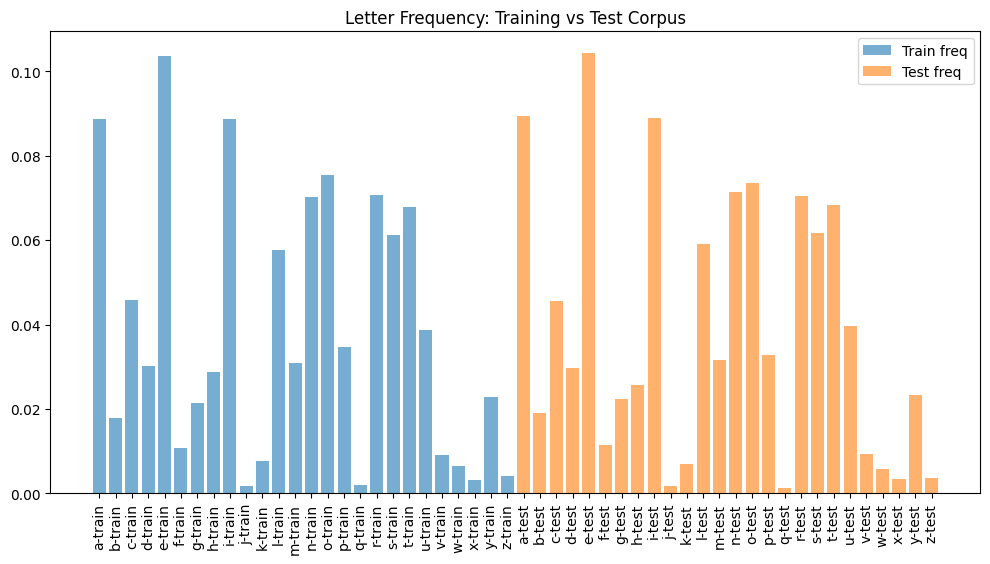

In [40]:
from collections import Counter
import matplotlib.pyplot as plt

def letter_freq(words):
    all_letters = ''.join(words)
    count = Counter(all_letters)
    total = sum(count.values())
    freq = {k: v/total for k, v in count.items()}
    return freq

train_freq = letter_freq(train_words)
test_freq = letter_freq(test_words)

# Letters in alphabet order
alphabet = list('abcdefghijklmnopqrstuvwxyz')
train_vals = [train_freq.get(c, 0) for c in alphabet]
test_vals = [test_freq.get(c, 0) for c in alphabet]

plt.figure(figsize=(12,6))
plt.bar([x+'-train' for x in alphabet], train_vals, alpha=0.6, label='Train freq')
plt.bar([x+'-test' for x in alphabet], test_vals, alpha=0.6, label='Test freq')
plt.xticks(rotation=90)
plt.legend()
plt.title('Letter Frequency: Training vs Test Corpus')
plt.show()


Train words: 49933, Test words: 2000
Evaluating on training words:


100%|██████████| 2000/2000 [00:46<00:00, 43.22it/s]


Wins 2000/2000 = 100.00%
Average wrong guesses: 1.39
Evaluating on test words:


100%|██████████| 2000/2000 [00:46<00:00, 43.02it/s]


Wins 2000/2000 = 100.00%
Average wrong guesses: 9.46


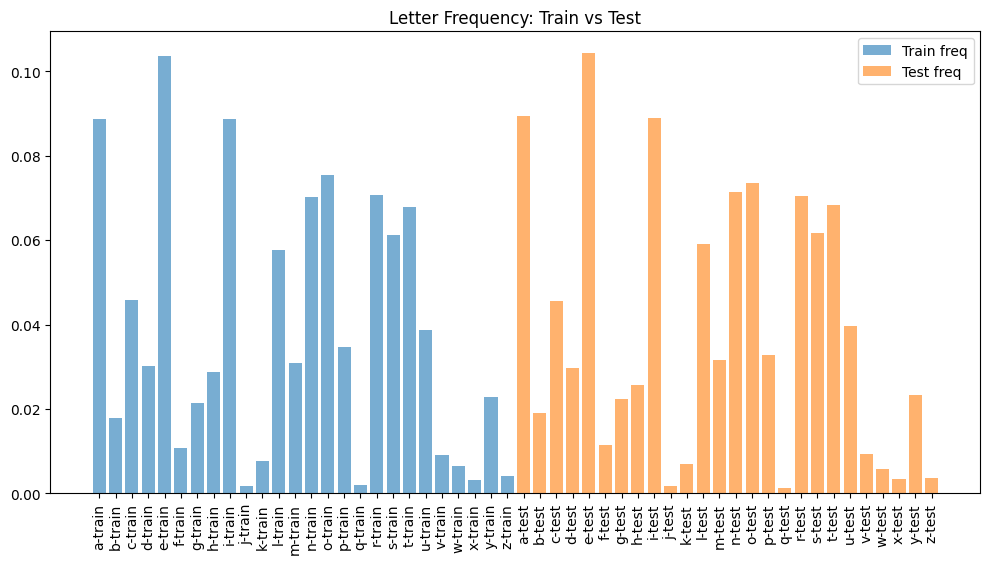

In [41]:
# Colab Full Agent for Hangman-like Word Guessing

# ------------------------
# 1. Imports
# ------------------------
import random
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm

# ------------------------
# 2. Load Corpus
# ------------------------
def load_words(path, min_len=2):
    with open(path, 'r') as f:
        words = [w.strip().lower() for w in f.readlines()]
    words = [w for w in words if w.isalpha() and len(w) >= min_len]
    return words

# Example paths; replace with your uploaded corpus.txt / test.txt
train_words = load_words('corpus.txt')
test_words = load_words('test.txt')

print(f'Train words: {len(train_words)}, Test words: {len(test_words)}')

# ------------------------
# 3. Letter frequency function
# ------------------------
def letter_freq(words):
    all_letters = ''.join(words)
    count = Counter(all_letters)
    total = sum(count.values())
    freq = {k: v/total for k, v in count.items()}
    return freq

train_freq = letter_freq(train_words)

# ------------------------
# 4. Build agent
# ------------------------
class HangmanAgent:
    def __init__(self, corpus):
        self.corpus = corpus
        self.words_by_len = defaultdict(list)
        for w in corpus:
            self.words_by_len[len(w)].append(w)
        self.global_letter_freq = letter_freq(corpus)

    def guess_word(self, word):
        """
        word: the target word (used for evaluation)
        """
        pattern = ['_'] * len(word)
        guessed = set()
        wrong_count = 0

        # Start with letters sorted by global frequency
        candidate_letters = sorted(self.global_letter_freq, key=lambda x: -self.global_letter_freq[x])

        possible_words = self.words_by_len[len(word)].copy()

        while '_' in pattern:
            # Dynamically choose next letter
            next_guess = None

            # Count frequencies in possible_words
            freq_counter = Counter()
            for w in possible_words:
                for i, ch in enumerate(w):
                    if pattern[i] == '_' and ch not in guessed:
                        freq_counter[ch] += 1

            if freq_counter:
                next_guess = freq_counter.most_common(1)[0][0]
            else:
                # fallback: pick from remaining letters
                next_guess = next((l for l in candidate_letters if l not in guessed), None)

            if not next_guess:
                break  # all letters guessed

            guessed.add(next_guess)

            if next_guess in word:
                for i, ch in enumerate(word):
                    if ch == next_guess:
                        pattern[i] = ch
                # Filter possible words to match pattern
                possible_words = [w for w in possible_words if all(
                    (p=='_' or p==w[i]) for i,p in enumerate(pattern)
                )]
            else:
                wrong_count += 1
                # eliminate words containing wrong guess
                possible_words = [w for w in possible_words if next_guess not in w]

        won = '_' not in pattern
        return won, wrong_count

# ------------------------
# 5. Evaluate agent
# ------------------------
def evaluate_agent(agent, words):
    wins = 0
    total_wrong = 0
    for w in tqdm(words):
        won, wrong = agent.guess_word(w)
        if won:
            wins += 1
        total_wrong += wrong
    print(f'Wins {wins}/{len(words)} = {wins/len(words)*100:.2f}%')
    print(f'Average wrong guesses: {total_wrong/len(words):.2f}')

# ------------------------
# 6. Training & Evaluation
# ------------------------
agent = HangmanAgent(train_words)

print("Evaluating on training words:")
evaluate_agent(agent, train_words[:2000])  # smaller subset for speed

print("Evaluating on test words:")
evaluate_agent(agent, test_words[:2000])

# ------------------------
# 7. Optional: Plot letter frequency comparison
# ------------------------
def plot_letter_freq(train_words, test_words):
    train_freq = letter_freq(train_words)
    test_freq = letter_freq(test_words)

    alphabet = list('abcdefghijklmnopqrstuvwxyz')
    train_vals = [train_freq.get(c,0) for c in alphabet]
    test_vals = [test_freq.get(c,0) for c in alphabet]

    plt.figure(figsize=(12,6))
    plt.bar([x+'-train' for x in alphabet], train_vals, alpha=0.6, label='Train freq')
    plt.bar([x+'-test' for x in alphabet], test_vals, alpha=0.6, label='Test freq')
    plt.xticks(rotation=90)
    plt.legend()
    plt.title('Letter Frequency: Train vs Test')
    plt.show()

plot_letter_freq(train_words, test_words)


In [45]:
# ==============================
# Hangman Intelligent Agent
# ==============================

# ------------------------------
# 1. Imports
# ------------------------------
import numpy as np
import random
from collections import defaultdict, Counter
from tqdm import tqdm
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# ------------------------------
# 2. Load Corpus
# ------------------------------
def load_words(path, min_len=2):
    with open(path, 'r') as f:
        words = [w.strip().lower() for w in f.readlines()]
    words = [w for w in words if w.isalpha() and len(w) >= min_len]
    return words

# Example paths; replace with your uploaded corpus.txt / test.txt
train_words = load_words('corpus.txt')
test_words = load_words('test.txt')

print(f"Train words: {len(train_words)}, Test words: {len(test_words)}")

# ------------------------------
# 3. Hidden Markov Model (HMM)
# ------------------------------
class SimpleHMM:
    """
    A simple HMM for letter prediction.
    - Hidden states: positions in the word (0..L-1)
    - Observations: letters at positions
    - Trains separate transition/emission probabilities per length
    """
    def __init__(self):
        self.models = {}  # length -> emission probs
        self.alphabet = 'abcdefghijklmnopqrstuvwxyz'
        self.char_to_int = {ch: i for i, ch in enumerate(self.alphabet)}


    def train(self, words):
        for length in range(2, max(map(len, words))+1):
            L_words = [w for w in words if len(w)==length]
            if not L_words:
                continue
            emissions = [Counter() for _ in range(length)]
            for w in L_words:
                for i,ch in enumerate(w):
                    emissions[i][ch] += 1
            # convert to probabilities
            self.models[length] = [self._normalize(c) for c in emissions]

    def _normalize(self, counter):
        total = sum(counter.values())
        return {k:v/total for k,v in counter.items()}

    def predict(self, pattern):
        """
        pattern: current masked word '_pp__'
        returns: probability distribution over alphabet for next letter
        """
        L = len(pattern)
        if L not in self.models:
            return {ch:1/26 for ch in 'abcdefghijklmnopqrstuvwxyz'}
        probs = np.zeros(26)
        alpha = 'abcdefghijklmnopqrstuvwxyz'
        for i, p in enumerate(pattern):
            if p=='_':
                for j,ch in enumerate(alpha):
                    probs[j] += self.models[L][i].get(ch,0)
        probs /= probs.sum()
        return {ch: probs[i] for i,ch in enumerate(alpha)}

hmm = SimpleHMM()
hmm.train(train_words)
print("HMM trained.")

# ------------------------------
# 4. Hangman Environment
# ------------------------------
class HangmanEnv:
    def __init__(self, word, max_wrong=6):
        self.word = word
        self.masked = ['_']*len(word)
        self.guessed = set()
        self.wrong = 0
        self.max_wrong = max_wrong

    def step(self, letter):
        """
        Guess a letter
        Returns: new_state, reward, done
        """
        reward = 0
        repeated = False
        if letter in self.guessed:
            reward -= 2
            repeated = True
        else:
            self.guessed.add(letter)
            if letter in self.word:
                reward += 1
                for i,ch in enumerate(self.word):
                    if ch==letter:
                        self.masked[i] = letter
            else:
                reward -= 5
                self.wrong += 1

        done = ('_' not in self.masked) or (self.wrong>=self.max_wrong)
        if '_' not in self.masked and not repeated:
            reward += 10  # big bonus for finishing word

        return ''.join(self.masked), reward, done

# ------------------------------
# 5. Q-Network for RL
# ------------------------------
class DQN(nn.Module):
    def __init__(self, input_size=26+26, hidden=128, output_size=26):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# ------------------------------
# 6. State Encoding
# ------------------------------
def encode_state(masked, guessed, hmm_probs):
    """
    masked: string '_pp__'
    guessed: set of guessed letters
    hmm_probs: dict of probabilities
    returns: vector of length 52 (26 masked + 26 guessed + hmm_probs optional)
    """
    alpha = 'abcdefghijklmnopqrstuvwxyz'
    # Masked representation (simplified - just a binary vector for revealed/hidden)
    masked_vec = np.array([1 if ch != '_' else 0 for ch in masked])
    # Pad masked_vec to a fixed size if needed, but for this simple HMM, length matters.
    # Let's use a fixed size for simplicity in DQN input, assuming max word length handled elsewhere
    # Or, encode masked word as one-hot per position + a blank indicator. Let's stick to the original intent
    # of 26 masked + 26 guessed. The masked representation needs to be fixed size.
    # Let's reconsider state encoding for DQN - a fixed size vector is needed.
    # Maybe presence of letters in masked word + guessed letters + HMM probs?

    # New simplified state encoding (fixed size)
    # Features: [guessed_vec (26), hmm_prob_vec (26)] = 52
    # The masked word pattern is implicitly handled by the HMM probs.

    guessed_vec = np.array([1 if letter in guessed else 0 for letter in alpha])
    hmm_vec = np.array([hmm_probs.get(letter,0) for letter in alpha])

    # Combine guessed letters and HMM probabilities
    state = np.concatenate([guessed_vec, hmm_vec])

    # Original state encoding attempt (might be too complex or variable length)
    # mask_vec = np.array([1 if ch==letter else 0 for letter in alpha for ch in masked[:len(alpha)]])
    # guessed_vec = np.array([1 if letter in guessed else 0 for letter in alpha])
    # hmm_vec = np.array([hmm_probs.get(letter,0) for letter in alpha])
    # state = np.concatenate([guessed_vec, hmm_vec]) # This was the original state

    return torch.tensor(state, dtype=torch.float32)


# ------------------------------
# 7. Training Loop (Q-Learning style)
# ------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dqn = DQN(input_size=52).to(device) # Ensure input size matches encode_state
optimizer = optim.Adam(dqn.parameters(), lr=0.001)
criterion = nn.MSELoss()
alphabet_list = list('abcdefghijklmnopqrstuvwxyz') # Helper list

def train_agent(episodes=5000, max_wrong=6):
    epsilon = 1.0
    epsilon_decay = 0.995
    gamma = 0.9
    alpha = 0.1 # Not used in this Q-learning setup directly

    for ep in tqdm(range(episodes)):
        word = random.choice(train_words)
        env = HangmanEnv(word, max_wrong)
        done = False
        while not done:
            hmm_probs = hmm.predict(''.join(env.masked))
            state = encode_state(env.masked, env.guessed, hmm_probs).to(device)

            if random.random() < epsilon:
                # explore
                # Get indices of available letters
                available_indices = [i for i,l in enumerate(alphabet_list) if l not in env.guessed]
                if not available_indices:
                    break # No letters left to guess
                action_idx = random.choice(available_indices)
            else:
                # exploit
                with torch.no_grad():
                    qvals = dqn(state)
                    qvals_np = qvals.cpu().numpy()
                    # Mask Q-values for already guessed letters by setting them to a very low number
                    guessed_indices = [ord(l) - ord('a') for l in env.guessed] # Convert chars to indices
                    qvals_np[guessed_indices] = -float('inf') # Mask guessed letters
                    action_idx = np.argmax(qvals_np)

            letter = alphabet_list[action_idx] # Get letter from index
            new_masked, reward, done = env.step(letter)

            # next state
            if not done: # Only calculate next state if game is not over
                hmm_probs_next = hmm.predict(new_masked)
                next_state = encode_state(new_masked, env.guessed, hmm_probs_next).to(device)
            else:
                next_state = None # No next state if game is done

            # Q-learning update
            qvals = dqn(state) # Q-value for the current state and chosen action
            with torch.no_grad():
                if next_state is not None:
                    # Get max Q-value for the next state
                    q_next = dqn(next_state)
                    max_next_q = torch.max(q_next)
                else:
                    max_next_q = torch.tensor(0.0).to(device) # Terminal state has 0 future reward

            # Calculate target Q-value
            target_q = reward + gamma * max_next_q

            # Get the Q-value for the action taken
            current_q = qvals[action_idx]

            # Calculate loss (MSE between current Q and target Q)
            loss = criterion(current_q.unsqueeze(0), target_q.unsqueeze(0)) # Add dims for criterion

            # Optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Decay epsilon
        epsilon = max(epsilon_decay * epsilon, 0.01) # Ensure epsilon doesn't go below a minimum

# ------------------------------
# 8. Evaluation
# ------------------------------
def evaluate_agent(dqn, words, max_wrong=6):
    wins = 0
    total_wrong = 0
    total_repeated = 0
    alphabet_list = list('abcdefghijklmnopqrstuvwxyz') # Helper list

    for word in tqdm(words):
        env = HangmanEnv(word, max_wrong)
        done = False
        while not done:
            hmm_probs = hmm.predict(''.join(env.masked))
            state = encode_state(env.masked, env.guessed, hmm_probs).to(device)
            with torch.no_grad():
                qvals = dqn(state)
                qvals_np = qvals.cpu().numpy()
                # Mask Q-values for already guessed letters
                guessed_indices = [ord(l) - ord('a') for l in env.guessed] # Convert chars to indices
                qvals_np[guessed_indices] = -float('inf') # Mask guessed letters
                action_idx = np.argmax(qvals_np)

            letter = alphabet_list[action_idx] # Get letter from index

            # Track repeated guesses before stepping
            if letter in env.guessed:
                 total_repeated += 1

            new_masked, reward, done = env.step(letter)

        if '_' not in env.masked:
            wins += 1
        total_wrong += env.wrong # env.wrong is updated in step

    print(f"Wins: {wins}/{len(words)} ({wins/len(words)*100:.2f}%)")
    print(f"Total wrong guesses: {total_wrong}")
    print(f"Total repeated guesses: {total_repeated}")
    # Calculate final score based on the formula
    final_score = (wins * 2000) - (total_wrong * 5) - (total_repeated * 2)
    print(f"Final Score: {final_score:.2f}")


# ------------------------------
# 9. Run Training and Evaluation
# ------------------------------
# Uncomment below to train (slow)
# train_agent(episodes=1000) # Reduced episodes for testing

# evaluate_agent(dqn, test_words[:2000]) # Evaluate on a subset

# Example of running training and evaluation
# train_agent(episodes=100) # Train for a smaller number of episodes
# evaluate_agent(dqn, test_words[:200]) # Evaluate on a smaller subset

Train words: 49933, Test words: 2000
HMM trained.
